# Setup

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 4.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, f1_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import sklearn.tree as tree
import matplotlib.image as mpimg
from IPython.display import Image
import pydotplus
import itertools as it
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import os
import sys
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings
np.set_printoptions(threshold=100)
warnings.filterwarnings("ignore")

### Important parameters

In [ ]:
def return_var_names(x):
  names = []
  for i in range(len(x)):
    names.append('var'+str(x[i]) + '_Categorify')

  return tuple(names)

def unique_index(l_comb):
  index = []
  for x in l_comb:
    index += list(x)
  return list(set(index))

In [ ]:
categorical_feature_chosen = "var13"
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"
list_remove = [44, 45, 46, 47, 48, 49, 50, 51, 55, 62, 63, 64, 65, 66] #31]
list_remove = ['var'+str(x) for x in list_remove]
list_combined_idx = [(1,7), (1,20),(7,8),(7,20),(7,23),(7,28),(7,29), (7,39),(1,7,8),(1,7,14),(1,7,20),(1,7,23),(1,7,28),(1,7,29),(1,7,31),(1,7,39),(1,8,20),(1,8,23),(1,20,23),(1,20,28),(1,20,29),(1,20,39),(1,23,28),(2,3,8),(1,7,14),(1,7,23),(1,7,28),(1,7,29),(1,7,31),(1,7,39),(1,8,20),(1,8,23)]
list_combined = [return_var_names(x) for x in list_combined_idx]
columns_name = []

### Loading datasets

In [ ]:
df = pd.read_csv(PATH + "datasets/train.csv")
test = pd.read_csv(PATH + "datasets/test.csv")
submission_sample = pd.read_csv(PATH + "datasets/submission_sample.csv")
metadata = pd.read_csv(PATH + "datasets/metadata.csv")
metadata.columns = ["cod", "type"]

In [ ]:
num_dis = metadata[metadata.type == "Quantitativo discreto"].cod.to_list()
num_dis.remove("y")
num_con = metadata[metadata.type == "Quantitativo continua"].cod.to_list()
cat_nom = metadata[metadata.type == "Qualitativo nominal"].cod.to_list()
cat_nom.remove("id")
cat_ord = metadata[metadata.type == "Qualitativo ordinal"].cod.to_list() 
y = df["y"]

In [ ]:
test_id = test["id"]
test.drop(["id"], axis=1, inplace=True)
X_prepared = df.drop(["id", "y"], axis=1)

# Exploring Dataset

## Graphics

In [ ]:
df.head()

In [ ]:
df.y.mean()

0.2017984847412023

In [ ]:
def plot_sparse(df, col):
    stats = df[[col, 'y']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats_sort = stats['count'].value_counts().reset_index()
    stats_sort = stats_sort.sort_values('index')
    plt.figure(figsize=(15,4))
    plt.bar(stats_sort['index'].astype(str).values[0:20], stats_sort['count'].values[0:20])
    plt.title('Frequency of ' + str(col))
    plt.xlabel('Number frequency')
    plt.ylabel('Frequency')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


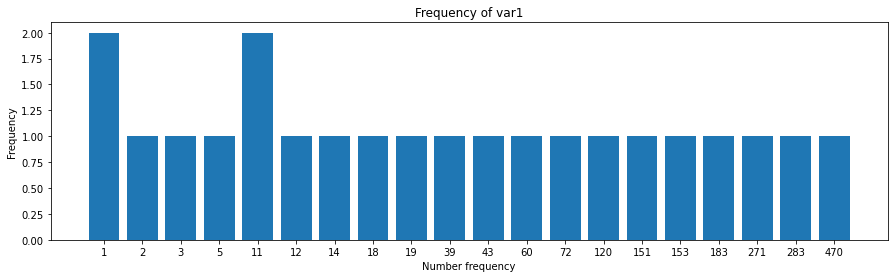

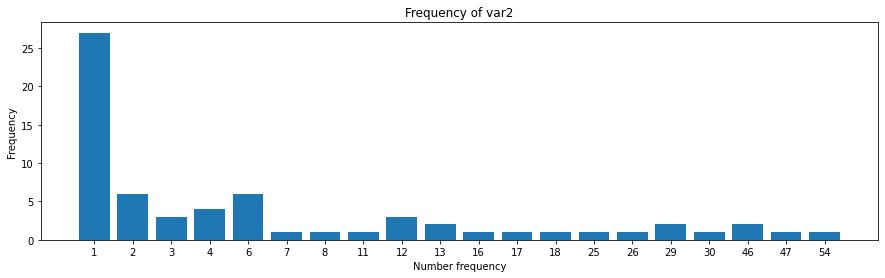

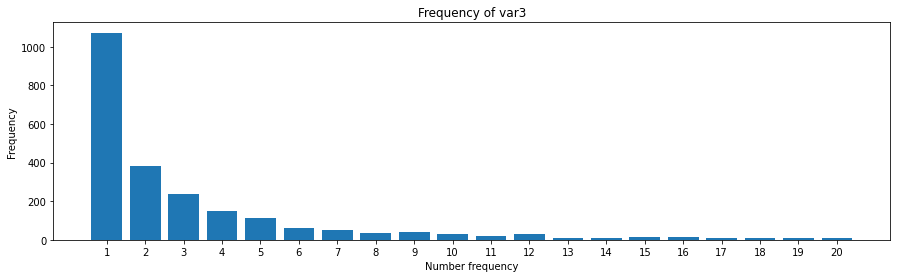

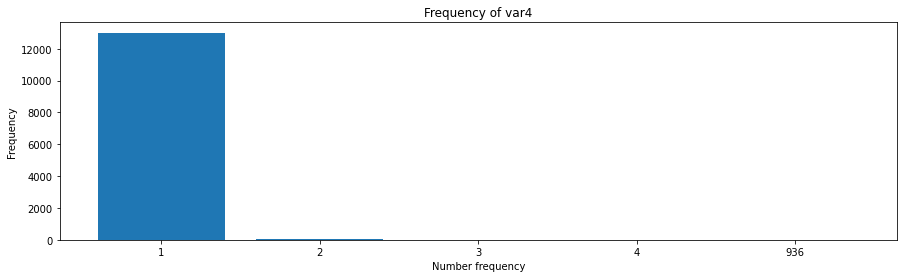

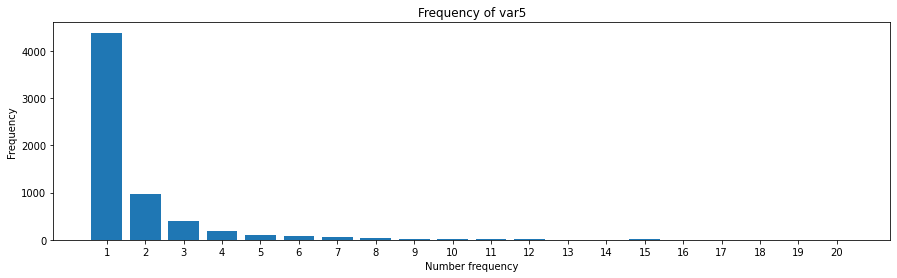

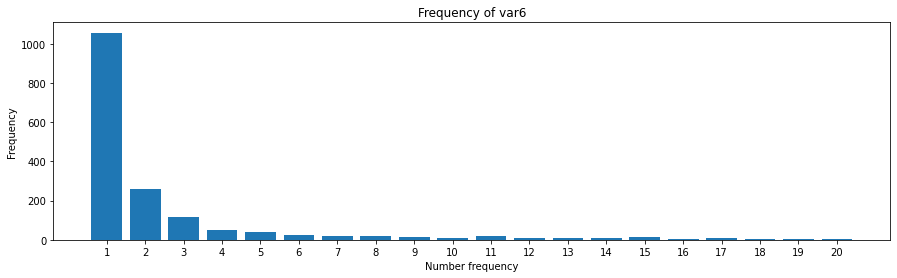

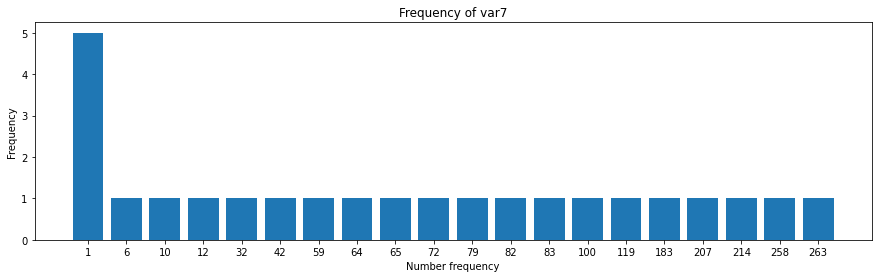

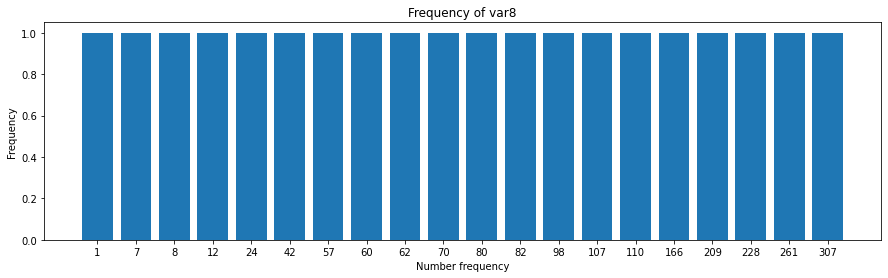

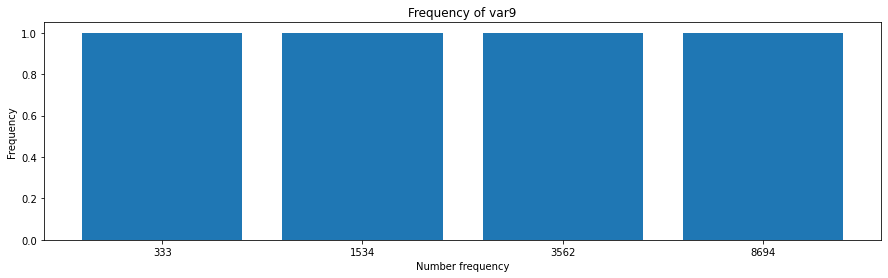

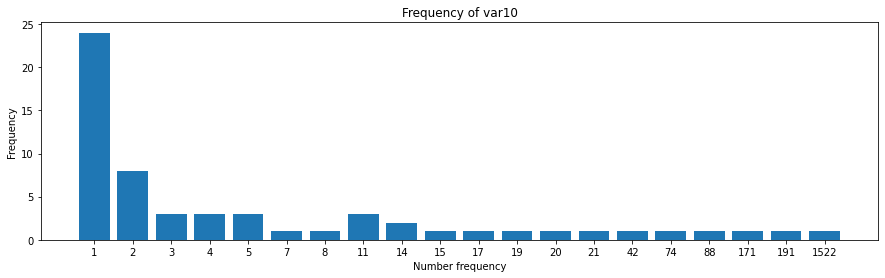

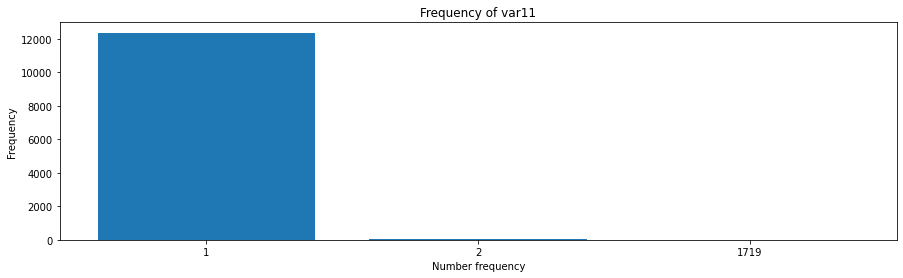

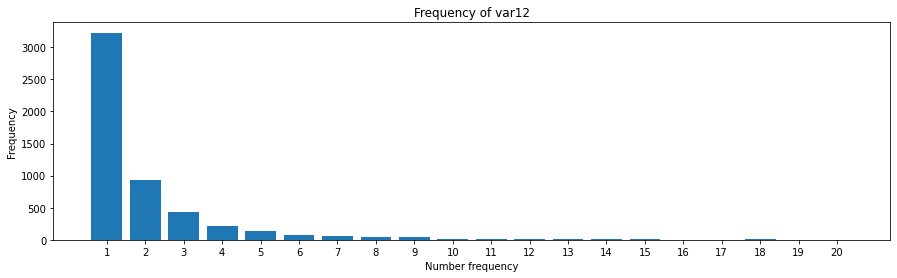

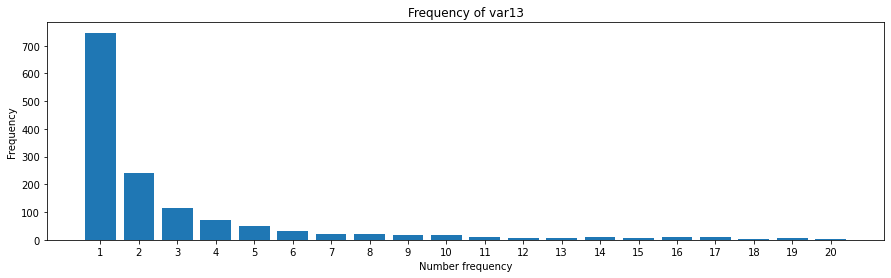

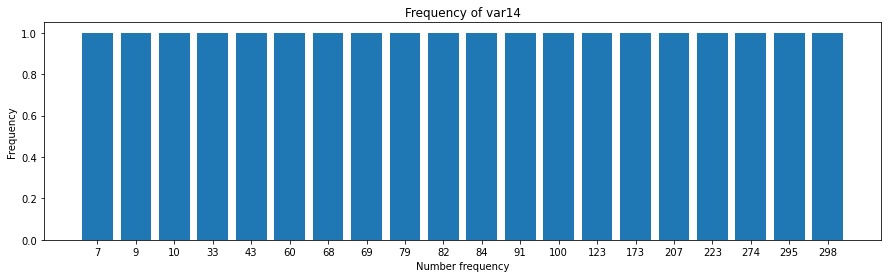

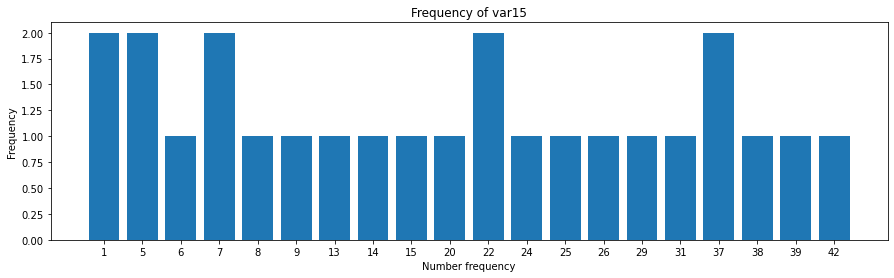

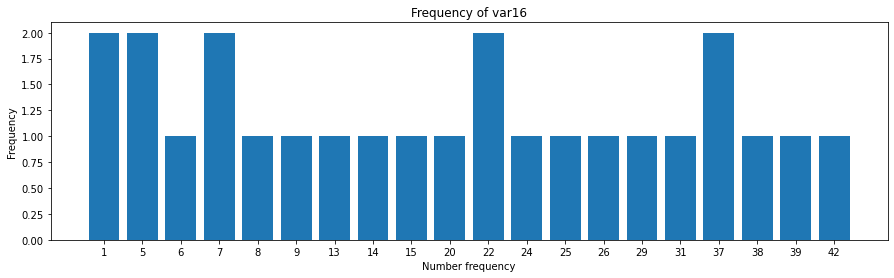

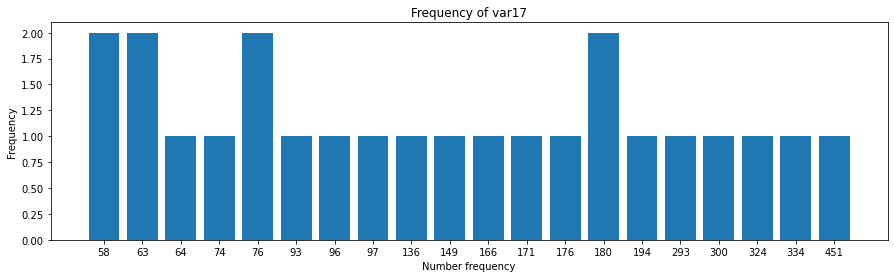

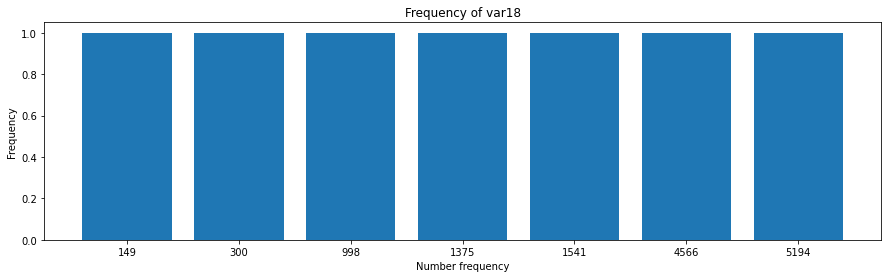

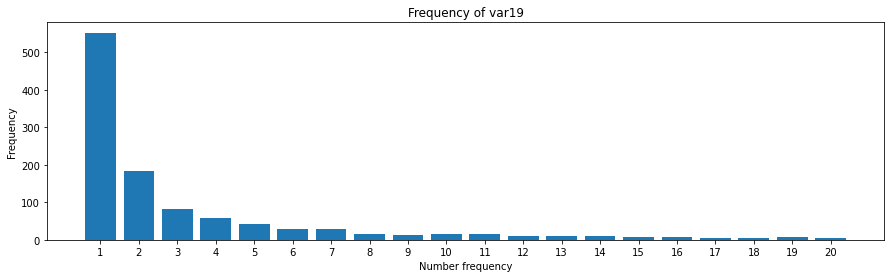

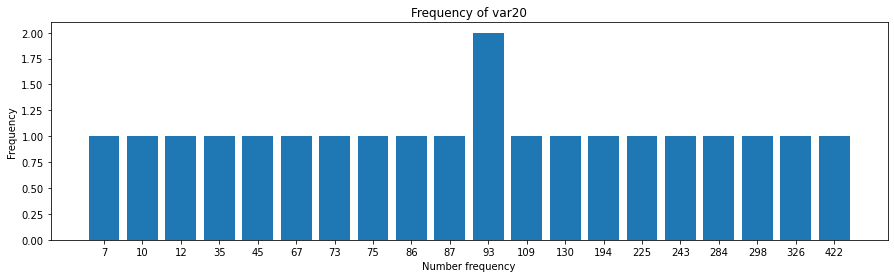

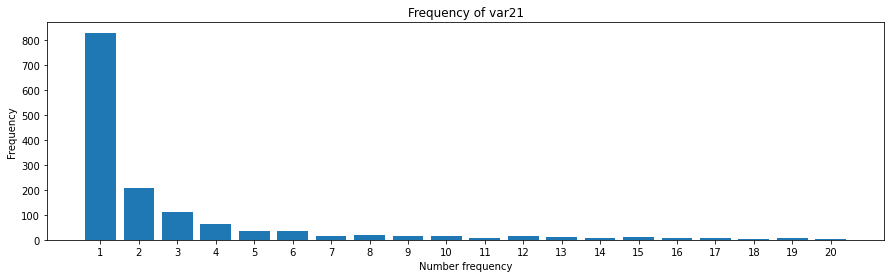

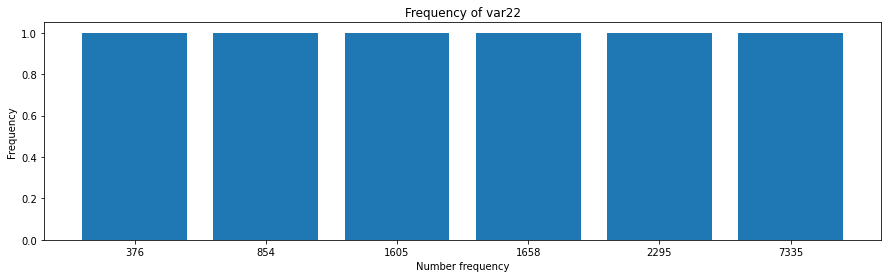

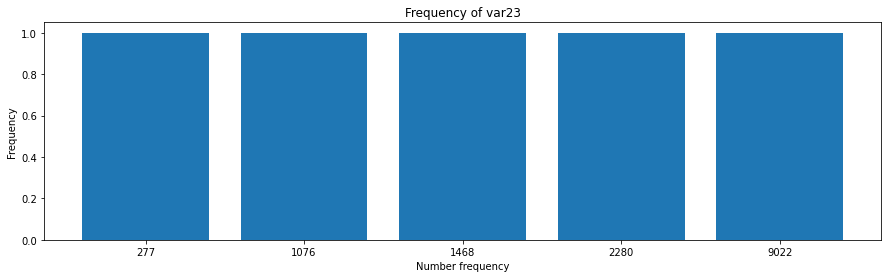

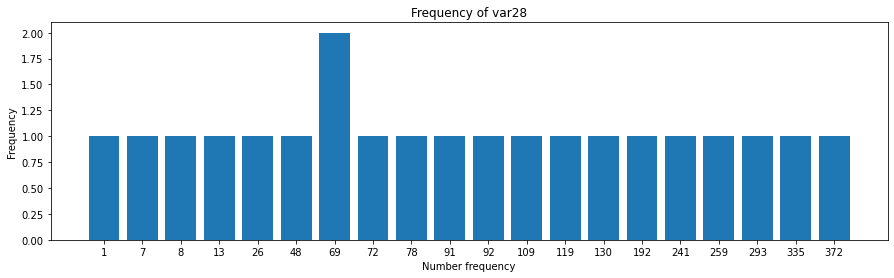

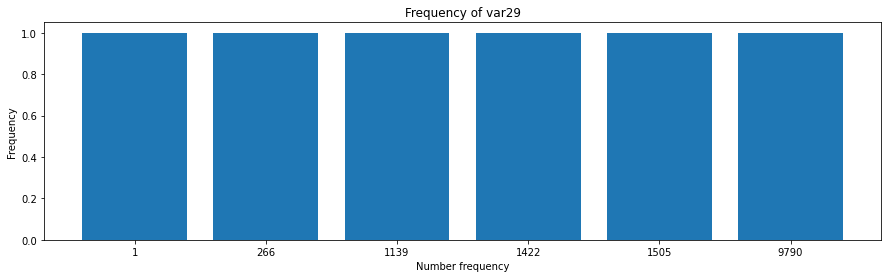

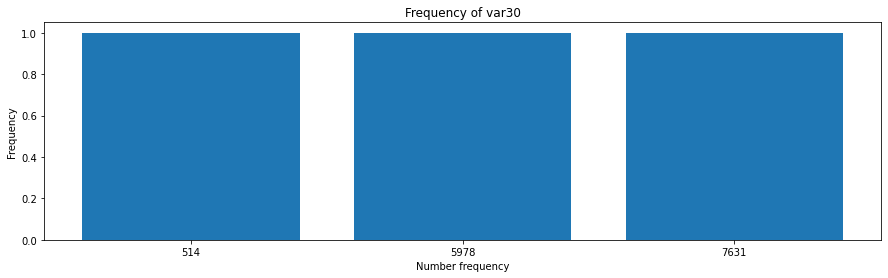

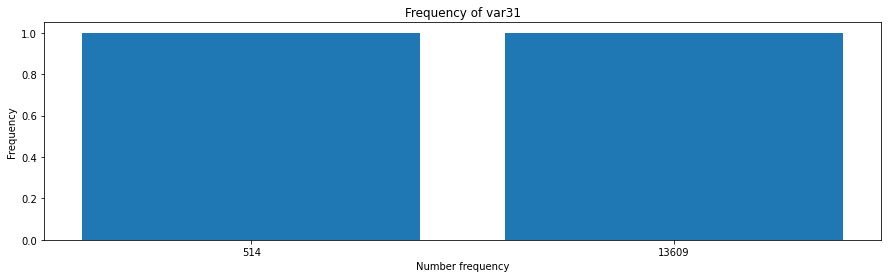

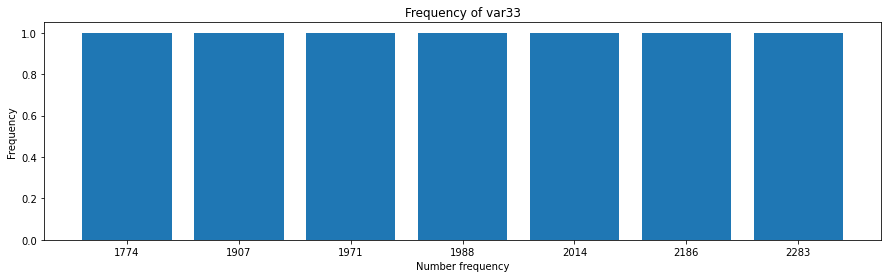

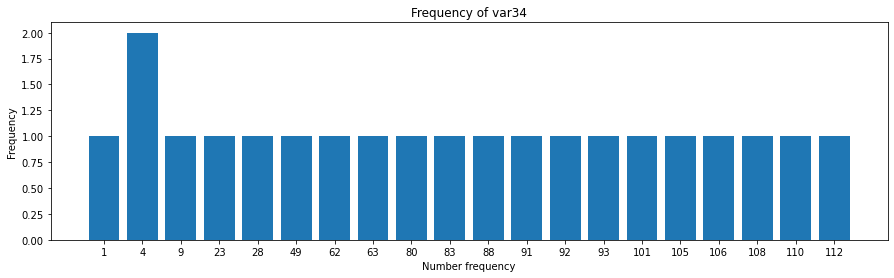

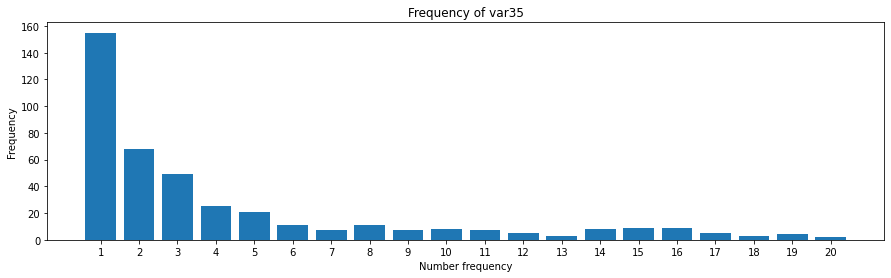

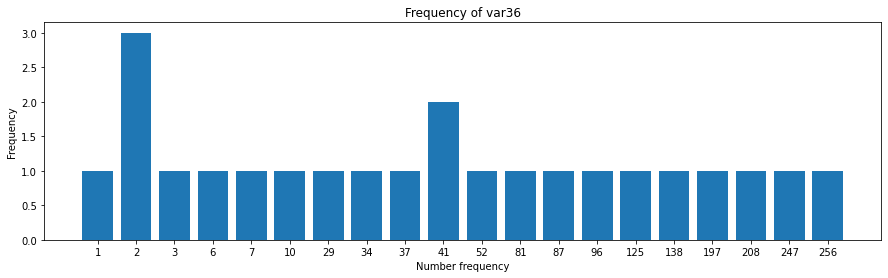

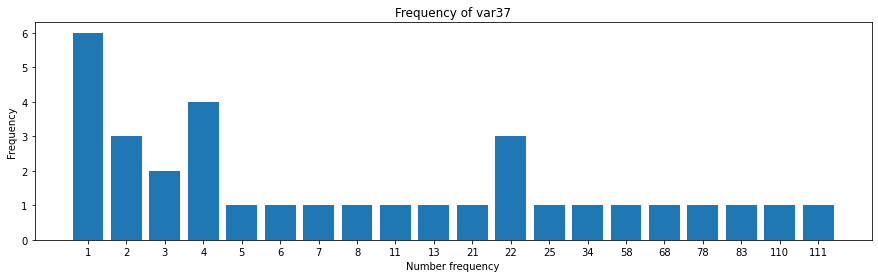

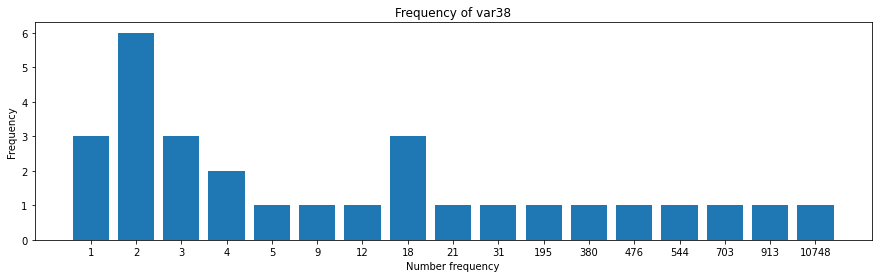

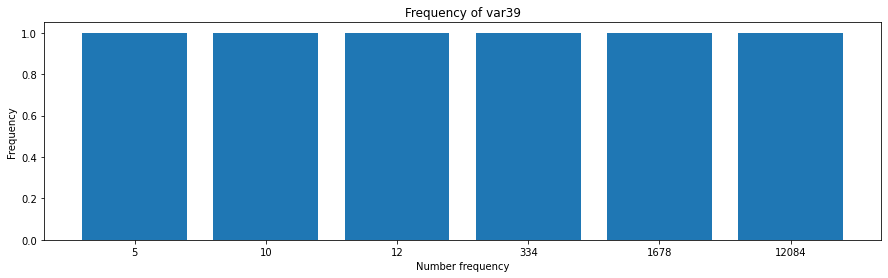

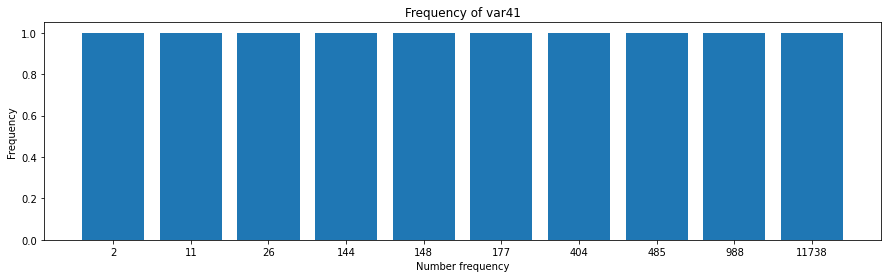

In [ ]:
for col in cat_nom:
  plot_sparse(df, col)

In [ ]:
def plot_top20(df, col):
    stats = df[[col, 'y']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats = stats.sort_values('count', ascending=False)
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.bar(stats[col].astype(str).values[0:20], stats['count'].values[0:20])
    ax1.set_xticklabels(stats[col].astype(str).values[0:20], rotation='vertical')
    ax2.plot(stats['mean'].values[0:20], color='red')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Mean Target')
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(col)
    ax1.set_title('Top20 ' + col + ' based on frequency')

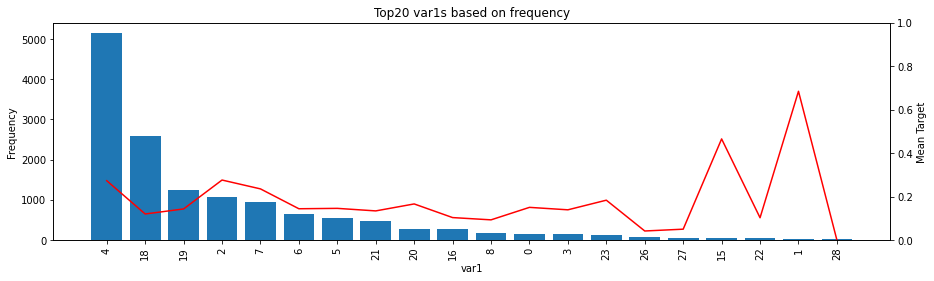

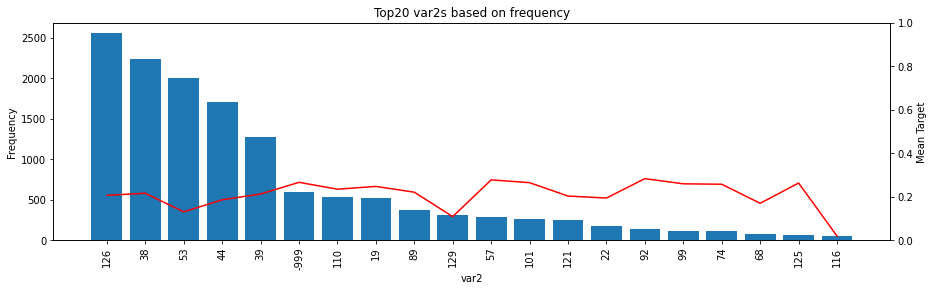

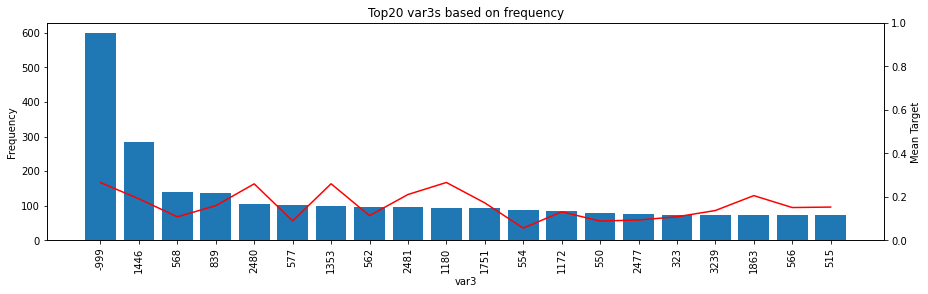

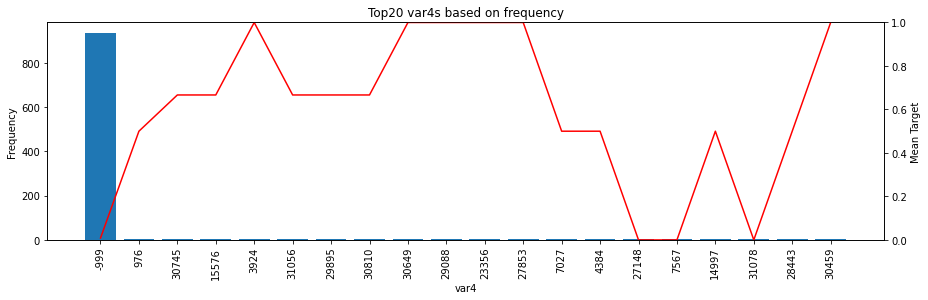

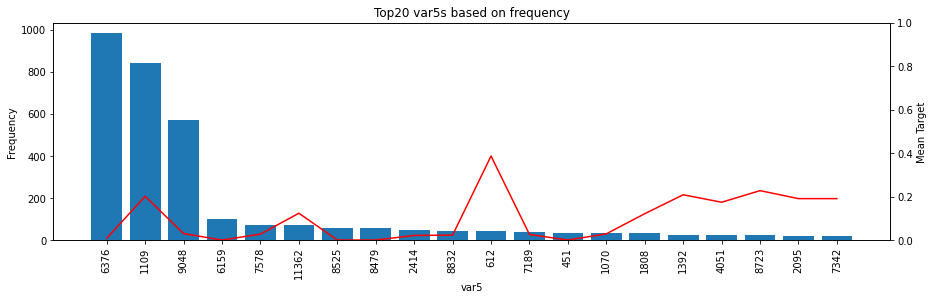

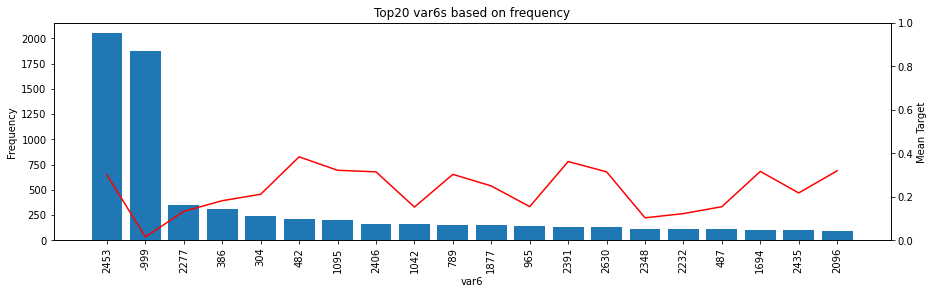

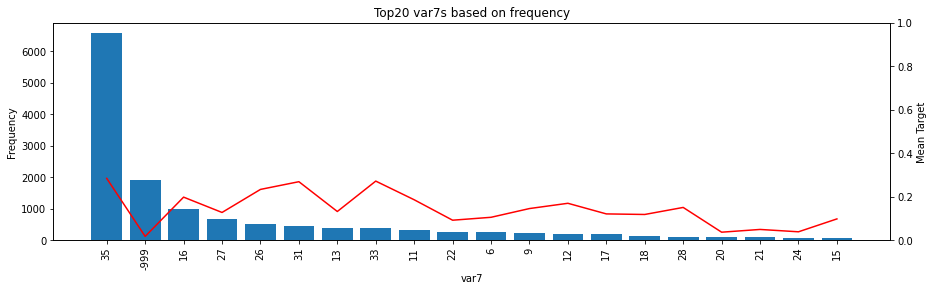

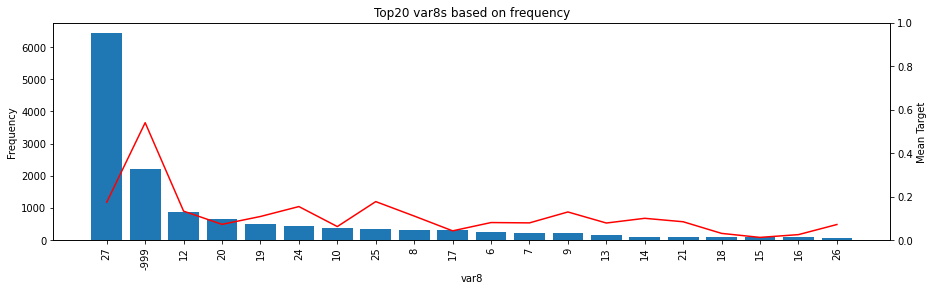

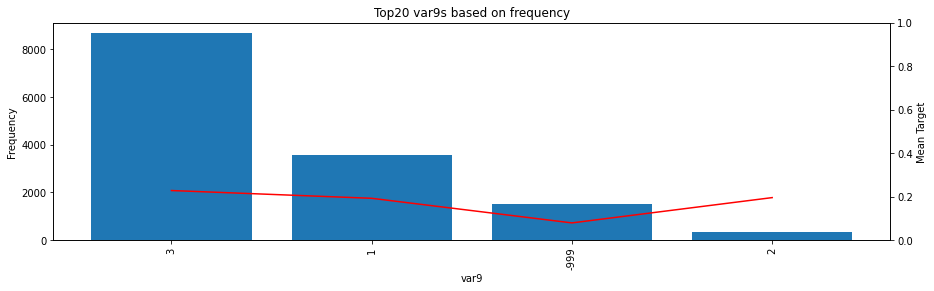

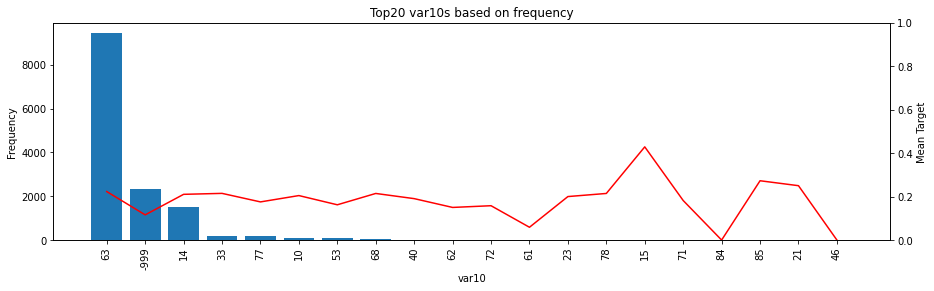

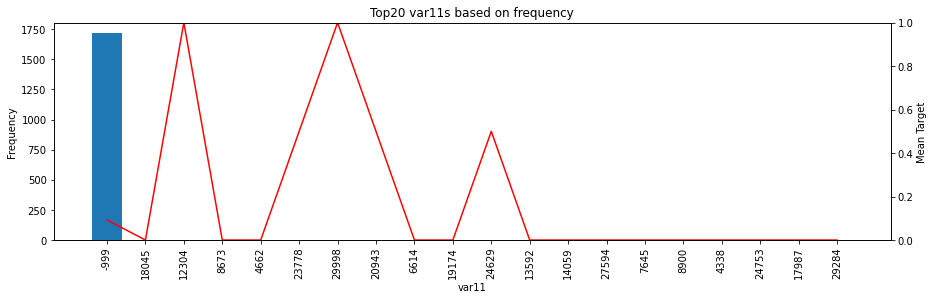

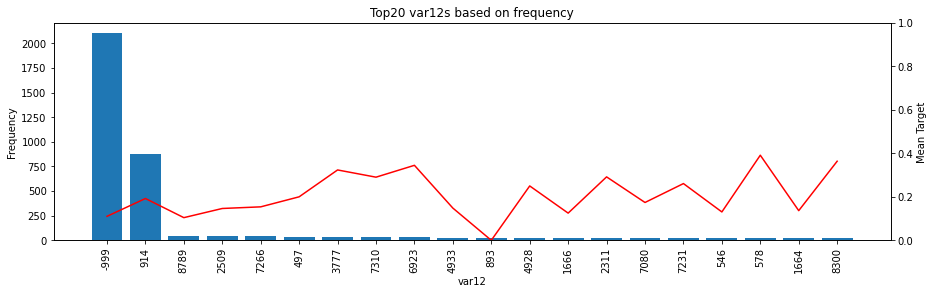

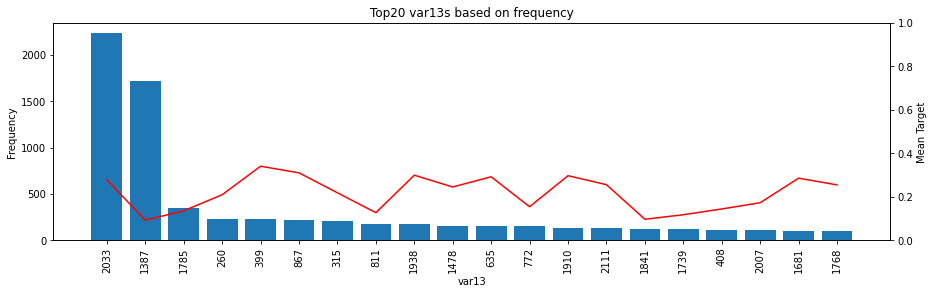

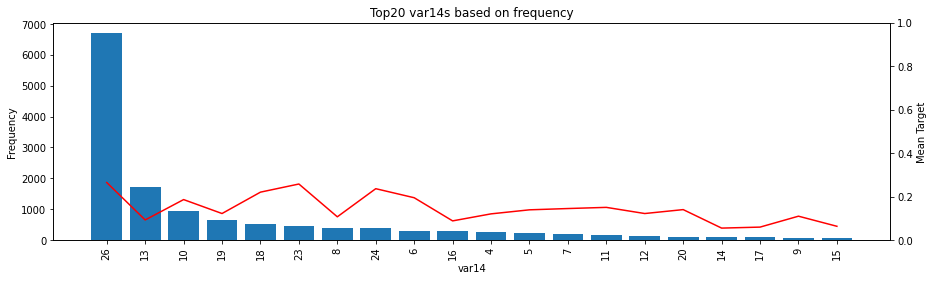

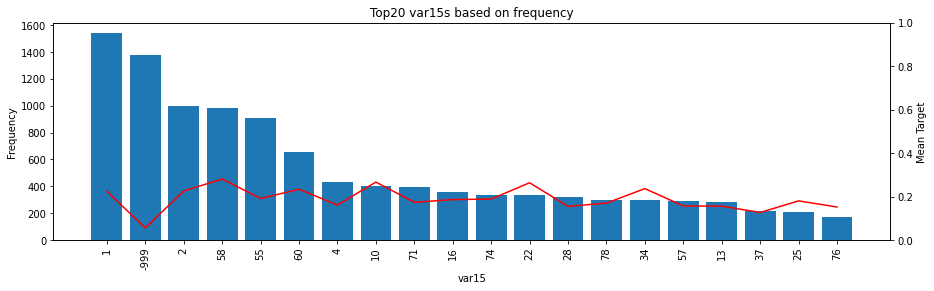

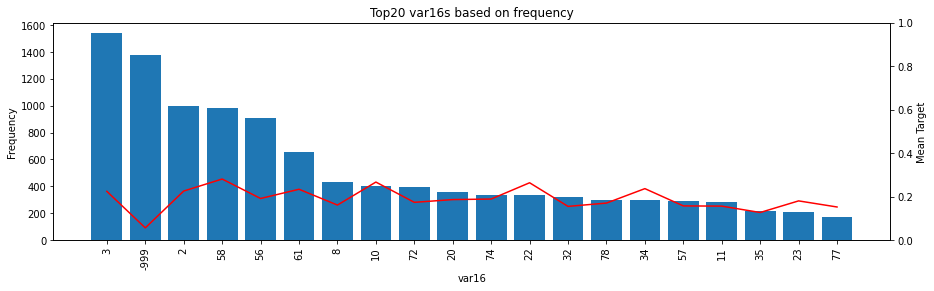

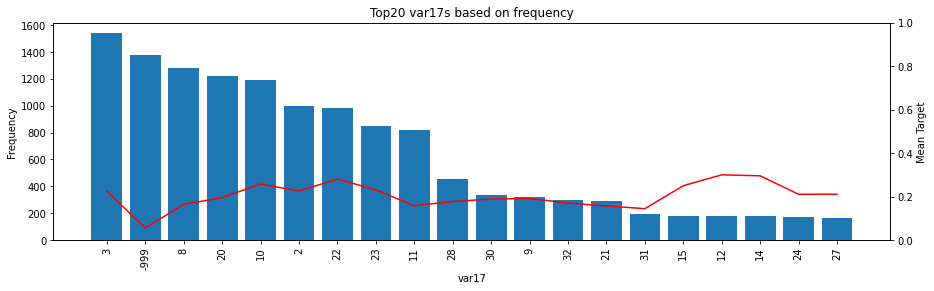

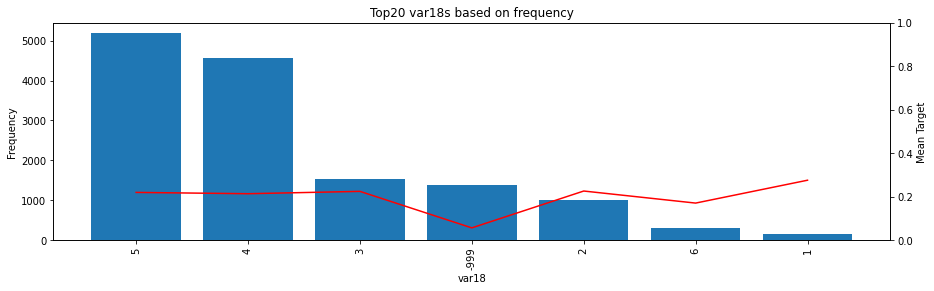

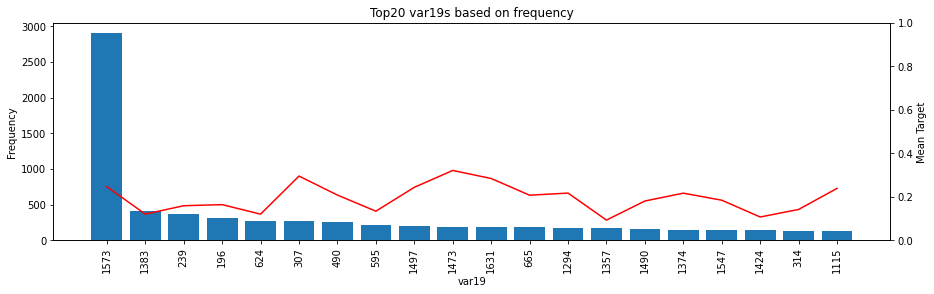

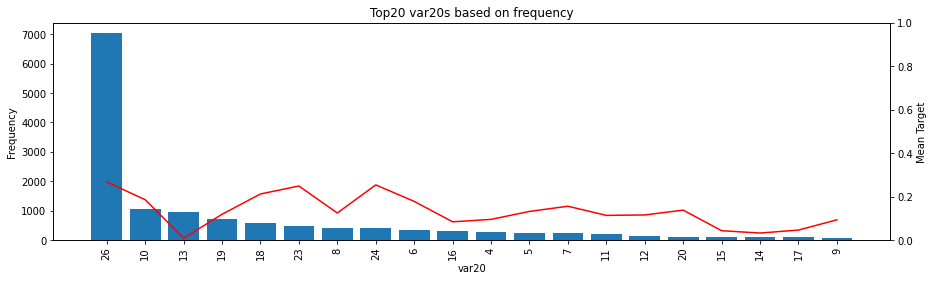

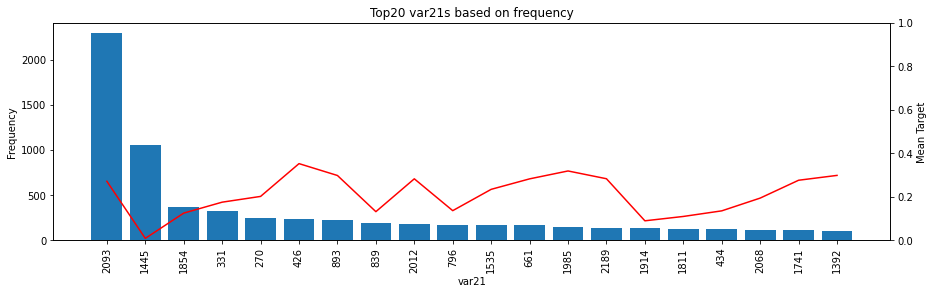

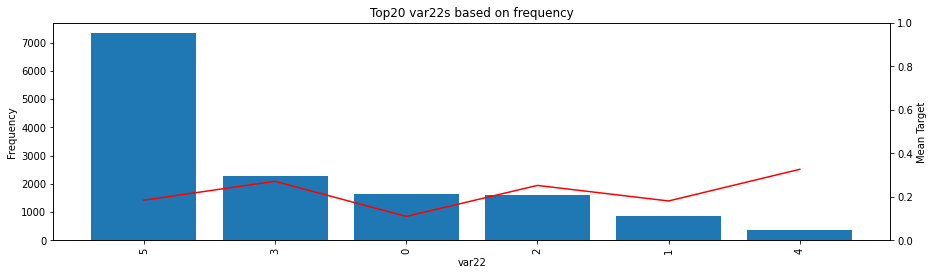

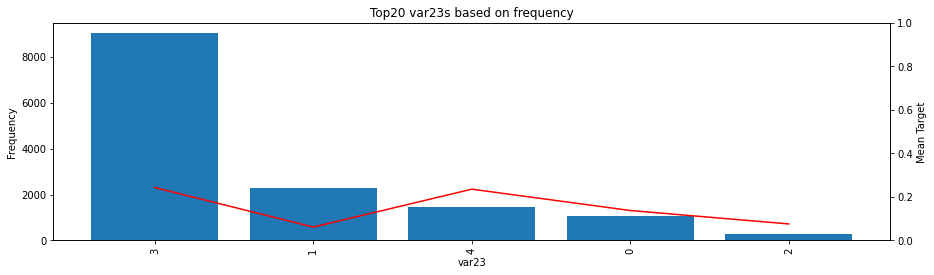

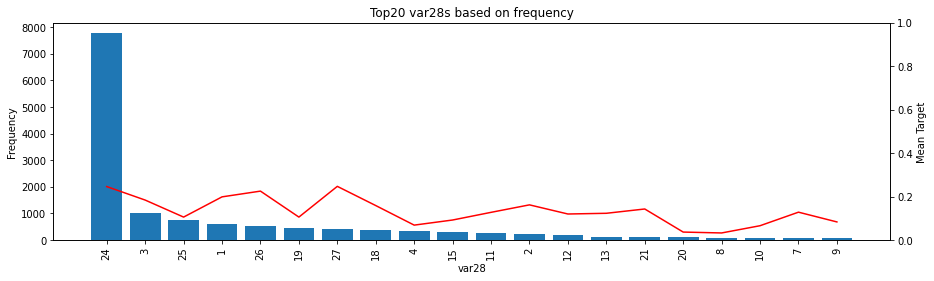

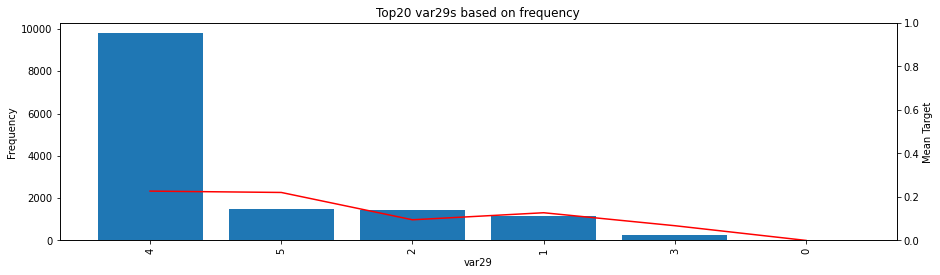

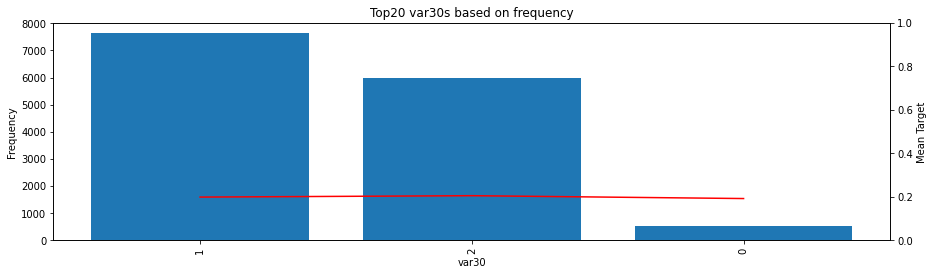

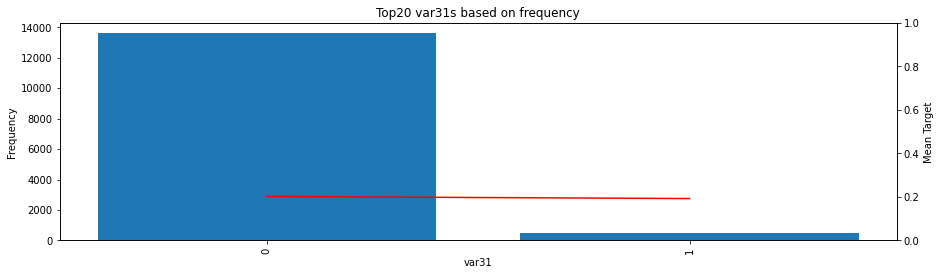

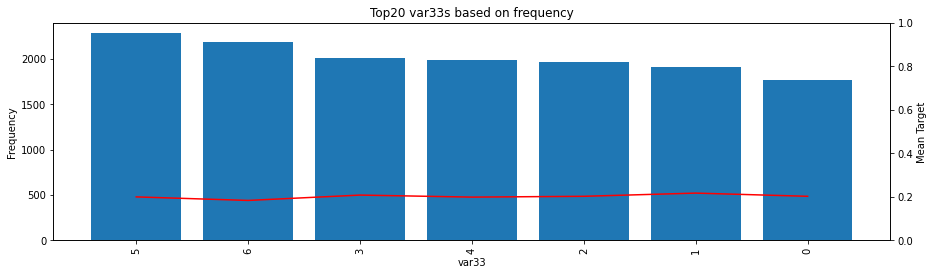

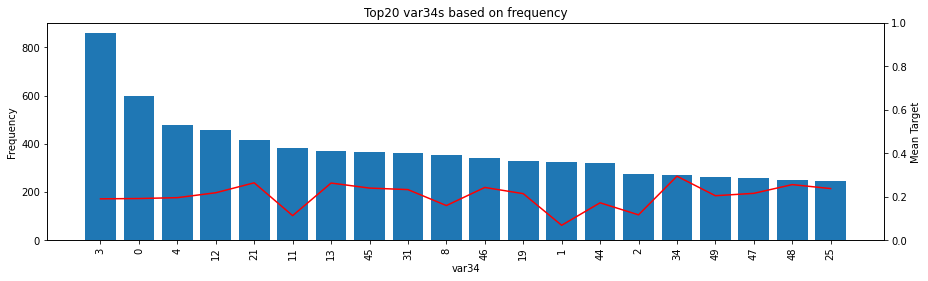

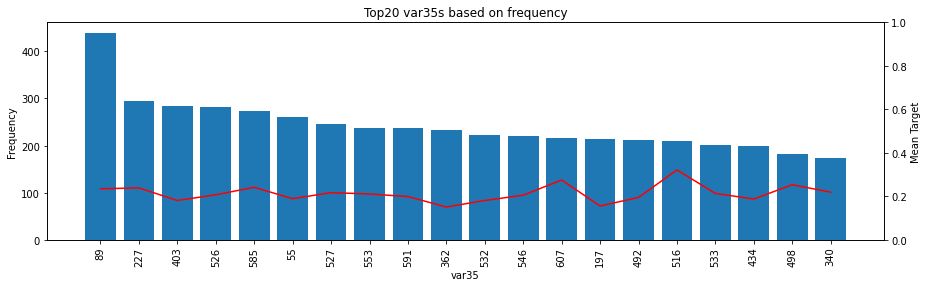

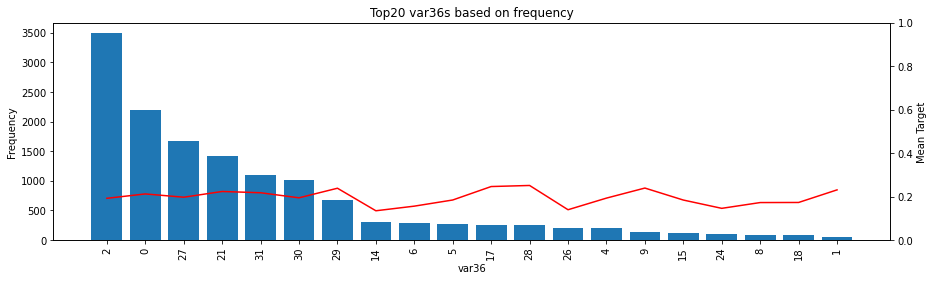

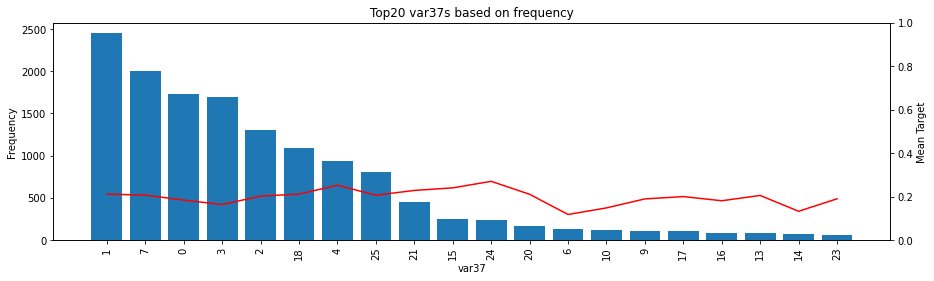

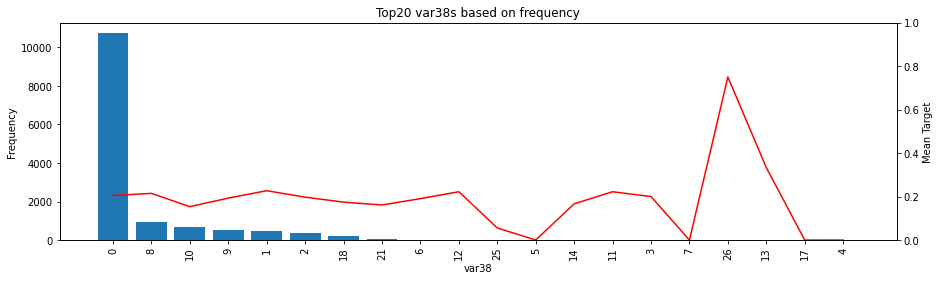

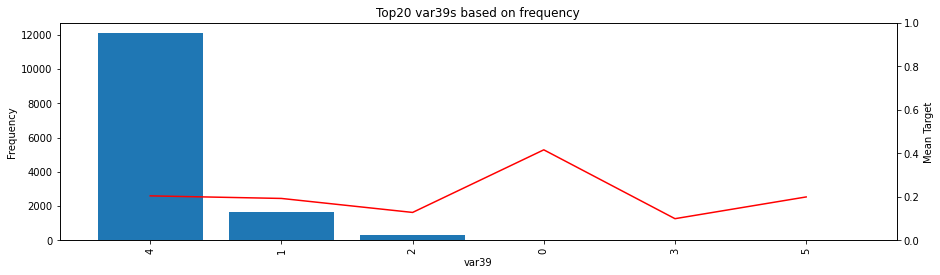

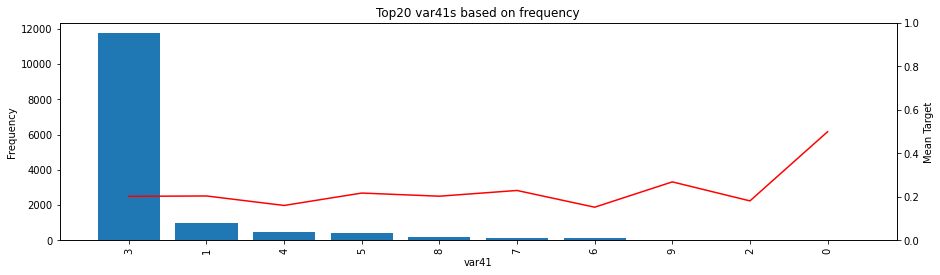

In [ ]:
for col in cat_nom:
  plot_top20(df, col)

## Missing Values

### Categorical features

In [ ]:
missing = X_train.replace(-999, np.nan).isna().sum().sort_values(ascending=False)
missing[missing.index.isin(cat_nom + cat_ord)]

var10    1883
var8     1767
var12    1680
var7     1521
var6     1505
var11    1384
var26    1277
var9     1245
var16    1125
var18    1125
var17    1125
var15    1125
var4      765
var3      485
var2      485
var14       0
var13       0
var19       0
var20       0
var21       0
var22       0
var23       0
var29       0
var5        0
var28       0
var34       0
var30       0
var31       0
var43       0
var42       0
var41       0
var39       0
var38       0
var37       0
var36       0
var35       0
var33       0
var32       0
var1        0
dtype: int64

In [ ]:
for col in cat_nom + cat_ord:
    X_train[col] = X_train[col].replace(-999, np.nan)
    if X_train[col].isna().sum() != 0:
      X_train['NA_' + col] = X_train[col].isna().astype(np.int8)
      X_train[col].fillna('UNKNOWN', inplace=True)

### Numerical features

In [ ]:
missing = X_train.replace(-999, np.nan).isna().sum().sort_values(ascending=False)
missing[missing.index.isin(num_dis + num_con)]

var66    9773
var65    9773
var60    5185
var59    1761
var57    1293
var56    1292
var58    1277
var52    1245
var67     474
var61     279
var68      23
var24       0
var25       0
var27       0
var64       0
var62       0
var63       0
var55       0
var45       0
var40       0
var44       0
var46       0
var54       0
var47       0
var48       0
var49       0
var50       0
var51       0
var53       0
dtype: int64

I'll choice the median of each categorical feature 'var1' to replace -999 values, but it can be changed in the future

In [ ]:
for col in num_dis + num_con:

  X_train[col] = X_train[col].replace(-999, np.nan)
  if X_train[col].isna().sum() == 0:
    continue
  X_median = X_train[[categorical_feature_chosen, col]] \
          .groupby(categorical_feature_chosen).median() \
          .reset_index()
  col_name = col + '_median_per_' + categorical_feature_chosen
  X_median.columns = [categorical_feature_chosen, col_name]
  X_train = X_train.merge(X_median, how='left', on=categorical_feature_chosen)
  X_train['NA_' + col] = X_train[col].isna().astype(np.int8)
  X_train.loc[X_train[col].isna(), col] = X_train.loc[X_train[col].isna(), col_name]
  X_train.drop(col_name, axis=1, inplace=True)

In [ ]:
X_train.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,...,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,NA_var2,NA_var3,NA_var4,NA_var6,NA_var7,NA_var8,NA_var9,NA_var10,NA_var11,NA_var12,NA_var15,NA_var16,NA_var17,NA_var18,NA_var26,NA_var52,NA_var67,NA_var68,NA_var56,NA_var57,NA_var58,NA_var59,NA_var60,NA_var61,NA_var65,NA_var66
0,4,101,78,27634,7214,2453,35,27,1,63,8337,404,2033,26,58,58,22,5,1573,26,2093,3,3,0,0,1,1,24,4,2,0,7,4,28,485,30,21,0,4,8,...,0.210672,0.079,0.967742,0.147247,0.098584,0.046143,0.132954,0.110347,0.988900,0.060641,0.255362,0.003015,0.205882,0.253676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4,126,169,7091,2613,152,13,10,3,63,28731,6788,499,26,73,73,29,5,624,8,113,0,0,2,1,10,0,19,1,1,0,16,1,11,195,2,2,0,4,4,...,0.211203,0.141,0.833333,0.148383,0.183344,0.133069,0.541860,0.038883,0.629667,0.022304,0.255362,0.003015,0.426471,0.158088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
2,7,99,3298,3208,6577,386,11,10,3,UNKNOWN,29993,5233,1462,6,7,9,9,4,1394,6,331,1,0,1,4,7,0,19,1,2,0,16,0,11,377,0,0,0,4,4,...,0.206052,0.210,0.451613,0.015367,0.257436,0.230439,0.397066,0.056352,0.885974,0.024463,0.255362,0.003015,0.058824,0.121324,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,18,38,2477,8955,8010,2453,35,27,3,63,8245,6301,2033,26,1,3,3,3,1573,26,2093,3,3,0,4,5,1,24,4,2,0,20,4,21,533,2,1,0,4,1,...,0.206480,0.727,0.101075,0.021123,0.125148,0.047092,0.545559,0.087387,0.364279,0.031872,0.278969,0.004020,0.294118,0.099265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,53,323,17696,6159,UNKNOWN,UNKNOWN,10,3,63,18858,914,952,10,40,42,8,4,78,10,990,5,3,1,4,8,0,19,1,2,0,7,3,11,526,2,18,0,4,10,...,0.204388,0.719,0.101075,0.315863,0.220287,0.133069,0.219114,0.061403,0.863774,0.023965,0.255362,0.003015,0.161765,0.176471,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1


## Combining Categories

In [ ]:
def get_hotn_features(df, add_features=[]):
  out = []
  col_name = [col + '_Categorify' for col in cat_nom + cat_ord]
  col_name += add_features
  for col in col_name:
    out.append(pd.get_dummies(df[col], prefix=col))
  return (pd.concat(out, axis=1))

def viz_tree(df, lf, add_features=[]):
  dt_feature_names = list(get_hotn_features(df, add_features).columns)
  # dt_feature_names = [col for col in df.columns if col != 'y']
  dt_target_names = 'y'
  tree.export_graphviz(lf, out_file='tree.dot', 
                         feature_names=dt_feature_names, class_names=["0","1"],
                         filled=True)  
  graph = pydotplus.graph_from_dot_file('tree.dot')
  return (graph.create_png())

In [ ]:
def display_img_array(ima):
    im = PIL.Image.fromarray(ima)
    bio = BytesIO()
    ima.save(ima, format='png')
    display(ima, format='png')

In [ ]:
pipelineComb = Pipeline([
    ('missing_values_categorical', ProcessMissingValues(columns=cat_nom + cat_ord)),
    ('categorify', Categorify(columns=cat_nom + cat_ord)),             
])

In [ ]:
X_comb = X_prepared.copy()
X_comb = pipelineComb.fit_transform(X_comb)
X_comb['y'] = y.to_numpy()

In [ ]:
X_comb.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,...,var1_Categorify,var2_Categorify,var3_Categorify,var4_Categorify,var5_Categorify,var6_Categorify,var7_Categorify,var8_Categorify,var9_Categorify,var10_Categorify,var11_Categorify,var12_Categorify,var13_Categorify,var14_Categorify,var15_Categorify,var16_Categorify,var17_Categorify,var18_Categorify,var19_Categorify,var20_Categorify,var21_Categorify,var22_Categorify,var23_Categorify,var28_Categorify,var29_Categorify,var30_Categorify,var31_Categorify,var33_Categorify,var34_Categorify,var35_Categorify,var36_Categorify,var37_Categorify,var38_Categorify,var39_Categorify,var41_Categorify,var26_Categorify,var32_Categorify,var42_Categorify,var43_Categorify,y
0,18,19,2853,29442,1386,2435,35,UNKNOWN,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,0,4,7,0,24,4,2,0,16,3,44,463,27,2,0,4,9,...,3,9,0,0,0,20,2,1,2,2,0,0,19,2,18,18,10,3,18,2,19,6,2,2,2,3,2,4,15,24,4,6,2,2,2,2,5,3,4,1
1,4,110,1986,13684,7189,UNKNOWN,UNKNOWN,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,2,1,6,1,4,2,1,0,14,0,1,532,2,1,0,4,7,...,2,8,198,0,13,1,1,11,2,2,0,7,0,11,2,2,2,4,0,11,0,2,3,10,4,2,2,8,14,12,2,2,2,2,2,8,7,13,6,0
2,0,39,1019,10232,678,791,16,UNKNOWN,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,2,1,7,0,3,4,1,0,11,1,3,81,26,3,0,4,3,...,13,6,0,0,46,219,4,1,2,2,0,54,295,4,16,16,6,3,113,3,237,2,2,3,2,2,2,7,2,53,14,5,2,2,2,2,10,7,3,0
3,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,0,0,1,1,19,1,2,0,8,0,11,414,27,0,0,4,10,...,10,6,12,0,0,10,8,8,3,4,0,0,9,8,34,34,9,2,6,8,9,4,5,7,5,3,2,8,7,32,4,4,2,2,2,4,14,9,10,0
4,7,44,2262,29428,6031,304,16,UNKNOWN,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,2,1,8,1,3,4,1,0,17,4,3,567,8,3,2,4,5,...,6,5,133,0,0,6,4,1,2,2,0,103,5,4,6,6,5,2,201,3,6,5,2,3,2,2,2,5,2,120,19,5,7,2,2,6,2,2,3,1


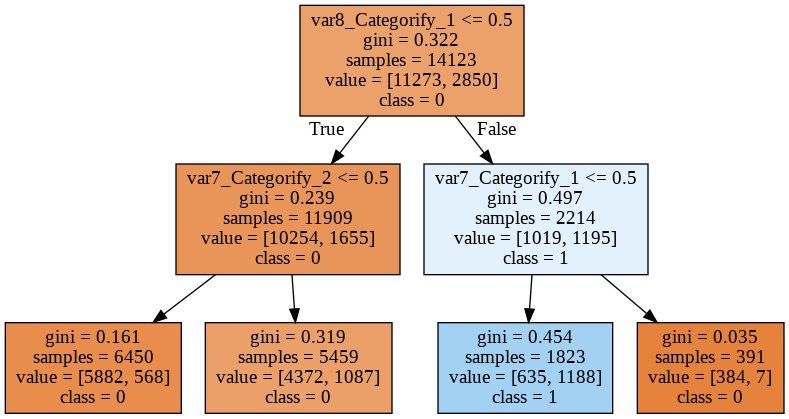

In [ ]:
lf = tree.DecisionTreeClassifier(max_depth=2)
lf.fit(get_hotn_features(X_comb), y)
Image(viz_tree(X_comb, lf))

I'll combine the categorical features two by two and I'll compare what combination is better for desicion tree.

In [ ]:
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image)

In [ ]:
for cols in list(it.combinations(cat_nom+cat_ord, 3)):
  lf = tree.DecisionTreeClassifier(max_depth=3)
  if cols[0] == cols[1]:
      continue
  df_copy = X_comb.copy()
  name_col = cols[0] + '_' + cols[1] + '_' + cols[2]
  df_copy[name_col] = X_comb[cols[0]].astype(str) + "_" +  X_comb[cols[1]].astype(str) + "_" + X_comb[cols[2]].astype(str)

  lf.fit(get_hotn_features(df_copy, [name_col]), df_copy[['y']])
  with open("{}trees/3/{}.png".format(PATH, name_col), "wb") as png:
    png.write(viz_tree(df_copy, lf, [name_col]))

FileNotFoundError: ignored

In [ ]:
df_copy = X_comb.copy()
name_col = []
for cols in list_combined:
  if len(cols) == 2:
    name_col.append(cols[0] + '_' + cols[1])
    df_copy[name_col[-1]] = X_comb[cols[0]].astype(str) + "_" +  X_comb[cols[1]].astype(str)
  else:
    name_col.append(cols[0] + '_' + cols[1] + '_' + cols[2])
    df_copy[name_col[-1]] = X_comb[cols[0]].astype(str) + "_" +  X_comb[cols[1]].astype(str) + '_' + X_comb[cols[2]].astype(str)

lf = tree.DecisionTreeClassifier(max_depth=5)
lf.fit(get_hotn_features(df_copy, name_col), df_copy[['y']])


In [ ]:
Image(viz_tree(df_copy, lf, name_col))

In [ ]:
for image in os.listdir(PATH + "trees/"):
  process(file)

## Categorifying

In [ ]:
for col in cat_nom + cat_ord:
  X_train[col], _ = X_train[col].factorize()

In [ ]:
class Categorify(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom + cat_ord, 
               freq_treshhold=20,
               lowfrequency_id=0,
                unkown_id=1):
    self.columns = columns
    self.freqs = []
    self.freq_treshhold = freq_treshhold
    self.lowfrequency_id = lowfrequency_id
    self.unkown_id = unkown_id

  def fit(self, X, y=None):
    for col in self.columns:
      freq = X[col].value_counts()
      freq = freq.reset_index()
      freq.columns = [col, 'count']
      freq = freq.reset_index()
      freq.columns = [col + '_Categorify', col, 'count']
      freq[col + '_Categorify'] = freq[col + '_Categorify']+2
      freq.loc[freq['count']<self.freq_treshhold, col + '_Categorify'] = self.lowfrequency_id
      freq.loc[freq[col]=='UNKNOWN', col + '_Categorify'] = self.unkown_id
      freq = freq.drop('count', axis=1)

      self.freqs.append(freq)
    return self

  def transform(self, X):
    for idx, col in enumerate(self.columns):
      X = X.merge(self.freqs[idx], how='left', on=col)
      X[col + '_Categorify'] = X[col + '_Categorify'].fillna(self.unkown_id).astype(np.int8)

    return X

In [ ]:
categorify = Categorify()
X_train = categorify.fit_transform(X_train)

## Target Encoding (TE)

In [ ]:
df_train = X_train.copy()
df_train["y"] = y_train.to_numpy()
df_train[['var1', 'y']].groupby('var1').mean()

,y
var1,
0,0.272178
1,0.223684
2,0.120917
3,0.134615
4,0.138945
5,0.126344
6,0.265589
7,0.138636
8,0.132743


In [ ]:
class TargetEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom + cat_ord):
    self.columns = columns
    self.tes = []

  def fit(self, X, y):
    df_X = X.copy()
    df_X["y"] = y.to_numpy()
    for col in self.columns:
      col_name = col + '_Categorify'
      te = df_X[[col_name, 'y']].groupby(col_name).mean()
      self.tes.append(te)
    return self

  def transform(self, X):
    for idx, col in enumerate(self.columns):
      col_name = col + '_Categorify'
      te = self.tes[idx]
      te = te.reset_index()
      te.columns = [col_name, 'TE_' + col]
      X = X.merge(te, how='left', on=col_name)

    return X

In [ ]:
te = TargetEncoding()
X_train = te.fit_transform(X_train, y_train)

## Count Encoding (CE)

In [ ]:
class CountEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom + cat_ord):
    self.columns = columns
    self.ces = []

  def fit(self, X, y=None):
    for col in self.columns:
      col_name = col + '_Categorify'
      ce = X[col_name].value_counts()
      self.ces.append(ce)
    return self

  def transform(self, X):
    for idx, col in enumerate(self.columns):
      col_name = col + '_Categorify'
      ce = self.ces[idx]
      ce = ce.reset_index()
      
      ce.columns = [col_name, 'CE_' + col]
      X = X.merge(ce, how='left', on=col_name)

    return X

In [ ]:
ce = CountEncoding()
X_train = ce.fit_transform(X_train, y_train)

## Get rid categorical features

In [ ]:
categority_col = [col for col in X_train.columns if 'Categorify' in col]
X_train.drop(cat_nom + cat_ord + categority_col, axis=1,inplace=True)
X_train.head()

,var24,var25,var27,var40,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,NA_var2,NA_var3,NA_var4,NA_var6,NA_var7,NA_var8,NA_var9,NA_var10,NA_var11,NA_var12,NA_var15,...,TE_var43,CE_var1,CE_var2,CE_var3,CE_var4,CE_var5,CE_var6,CE_var7,CE_var8,CE_var9,CE_var10,CE_var11,CE_var12,CE_var13,CE_var14,CE_var15,CE_var16,CE_var17,CE_var18,CE_var19,CE_var20,CE_var21,CE_var22,CE_var23,CE_var28,CE_var29,CE_var30,CE_var31,CE_var33,CE_var34,CE_var35,CE_var36,CE_var37,CE_var38,CE_var39,CE_var41,CE_var26,CE_var32,CE_var42,CE_var43
0,0,0,1,8,0,0,0,0,0,1,0,0,12.0,2,2,0.210672,0.079,0.967742,0.147247,0.098584,0.046143,0.132954,0.110347,0.988900,0.060641,0.255362,0.003015,0.205882,0.253676,0,0,0,0,0,0,0,0,0,0,0,...,0.187050,4137,204,9,1,8,1652,5253,5159,2824,7579,1,1,1789,5366,783,783,783,4138,2351,5623,1839,1839,7187,6244,7828,4783,10886,1623,154,107,809,356,8593,9681,9404,1754,577,1247,1807
1,2,1,0,4,1,0,0,0,0,0,0,1,51.0,2,2,0.211203,0.141,0.833333,0.148383,0.183344,0.133069,0.541860,0.038883,0.629667,0.022304,0.255362,0.003015,0.426471,0.158088,0,0,0,0,0,0,0,0,0,0,0,...,0.242525,4137,2049,3,1,9,26,326,309,6963,7579,1,6,11,5366,47,47,47,4138,206,347,26,1339,880,350,918,6103,10886,1549,300,63,2797,1045,8593,9681,9404,455,786,1417,301
2,1,4,0,4,1,0,0,0,0,1,0,0,56.0,2,2,0.206052,0.210,0.451613,0.015367,0.257436,0.230439,0.397066,0.056352,0.885974,0.024463,0.255362,0.003015,0.058824,0.121324,0,0,0,0,0,0,0,1,0,0,0,...,0.187050,760,94,3,1,4,259,261,309,6963,1883,1,4,5,249,78,78,259,3629,11,273,269,692,880,350,918,4783,10886,1389,300,107,1747,1353,8593,9681,9404,3226,786,1417,1807
3,0,4,1,1,1,1,1,0,1,1,0,0,18.0,1,1,0.206480,0.727,0.101075,0.021123,0.125148,0.047092,0.545559,0.087387,0.364279,0.031872,0.278969,0.004020,0.294118,0.099265,0,0,0,0,0,0,0,0,0,0,0,...,0.299213,2051,1784,58,1,2,1652,5253,5159,6963,7579,1,2,1789,5366,1245,1245,1245,1245,2351,5623,1839,1839,7187,6244,7828,4783,10886,1623,325,161,2797,1985,8593,9681,9404,1872,448,1247,127
4,1,4,0,10,1,0,0,0,0,0,1,0,23.0,3,3,0.204388,0.719,0.101075,0.315863,0.220287,0.133069,0.219114,0.061403,0.863774,0.023965,0.255362,0.003015,0.161765,0.176471,0,0,0,1,1,0,0,0,0,0,0,...,0.199207,2051,1616,61,1,82,1505,1521,309,6963,7579,1,698,1,749,121,121,1001,3629,29,825,1,5849,7187,350,918,4783,10886,1631,300,221,2797,869,8593,9681,9404,751,577,1247,2269


## Normalization


In [ ]:
X_train.head()

,var24,var25,var27,var40,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,NA_var2,NA_var3,NA_var4,NA_var6,NA_var7,NA_var8,NA_var9,NA_var10,NA_var11,NA_var12,NA_var15,...,TE_var43,CE_var1,CE_var2,CE_var3,CE_var4,CE_var5,CE_var6,CE_var7,CE_var8,CE_var9,CE_var10,CE_var11,CE_var12,CE_var13,CE_var14,CE_var15,CE_var16,CE_var17,CE_var18,CE_var19,CE_var20,CE_var21,CE_var22,CE_var23,CE_var28,CE_var29,CE_var30,CE_var31,CE_var33,CE_var34,CE_var35,CE_var36,CE_var37,CE_var38,CE_var39,CE_var41,CE_var26,CE_var32,CE_var42,CE_var43
0,0,0,1,8,0,0,0,0,0,1,0,0,12.0,2,2,0.210672,0.079,0.967742,0.147247,0.098584,0.046143,0.132954,0.110347,0.988900,0.060641,0.255362,0.003015,0.205882,0.253676,0,0,0,0,0,0,0,0,0,0,0,...,0.187050,4137,204,9,1,8,1652,5253,5159,2824,7579,1,1,1789,5366,783,783,783,4138,2351,5623,1839,1839,7187,6244,7828,4783,10886,1623,154,107,809,356,8593,9681,9404,1754,577,1247,1807
1,2,1,0,4,1,0,0,0,0,0,0,1,51.0,2,2,0.211203,0.141,0.833333,0.148383,0.183344,0.133069,0.541860,0.038883,0.629667,0.022304,0.255362,0.003015,0.426471,0.158088,0,0,0,0,0,0,0,0,0,0,0,...,0.242525,4137,2049,3,1,9,26,326,309,6963,7579,1,6,11,5366,47,47,47,4138,206,347,26,1339,880,350,918,6103,10886,1549,300,63,2797,1045,8593,9681,9404,455,786,1417,301
2,1,4,0,4,1,0,0,0,0,1,0,0,56.0,2,2,0.206052,0.210,0.451613,0.015367,0.257436,0.230439,0.397066,0.056352,0.885974,0.024463,0.255362,0.003015,0.058824,0.121324,0,0,0,0,0,0,0,1,0,0,0,...,0.187050,760,94,3,1,4,259,261,309,6963,1883,1,4,5,249,78,78,259,3629,11,273,269,692,880,350,918,4783,10886,1389,300,107,1747,1353,8593,9681,9404,3226,786,1417,1807
3,0,4,1,1,1,1,1,0,1,1,0,0,18.0,1,1,0.206480,0.727,0.101075,0.021123,0.125148,0.047092,0.545559,0.087387,0.364279,0.031872,0.278969,0.004020,0.294118,0.099265,0,0,0,0,0,0,0,0,0,0,0,...,0.299213,2051,1784,58,1,2,1652,5253,5159,6963,7579,1,2,1789,5366,1245,1245,1245,1245,2351,5623,1839,1839,7187,6244,7828,4783,10886,1623,325,161,2797,1985,8593,9681,9404,1872,448,1247,127
4,1,4,0,10,1,0,0,0,0,0,1,0,23.0,3,3,0.204388,0.719,0.101075,0.315863,0.220287,0.133069,0.219114,0.061403,0.863774,0.023965,0.255362,0.003015,0.161765,0.176471,0,0,0,1,1,0,0,0,0,0,0,...,0.199207,2051,1616,61,1,82,1505,1521,309,6963,7579,1,698,1,749,121,121,1001,3629,29,825,1,5849,7187,350,918,4783,10886,1631,300,221,2797,869,8593,9681,9404,751,577,1247,2269


In [ ]:
X_train.values

array([[0.000e+00, 0.000e+00, 1.000e+00, ..., 5.770e+02, 1.247e+03,
        1.807e+03],
       [2.000e+00, 1.000e+00, 0.000e+00, ..., 7.860e+02, 1.417e+03,
        3.010e+02],
       [1.000e+00, 4.000e+00, 0.000e+00, ..., 7.860e+02, 1.417e+03,
        1.807e+03],
       ...,
       [1.000e+00, 4.000e+00, 1.000e+00, ..., 6.200e+02, 1.154e+03,
        8.730e+02],
       [2.000e+00, 1.000e+00, 0.000e+00, ..., 7.860e+02, 1.722e+03,
        4.960e+02],
       [0.000e+00, 1.000e+00, 1.000e+00, ..., 2.890e+02, 3.050e+02,
        1.807e+03]])

In [ ]:
scaler = StandardScaler()
nun_columns = [col for col in X_train.columns if 'NA' not in col]
scaler.fit(X_train[nun_columns])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
X_train[nun_columns] = scaler.transform(X_train[nun_columns])

In [ ]:
X_train.head()

,var24,var25,var27,var40,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,NA_var2,NA_var3,NA_var4,NA_var6,NA_var7,NA_var8,NA_var9,NA_var10,NA_var11,NA_var12,NA_var15,...,TE_var43,CE_var1,CE_var2,CE_var3,CE_var4,CE_var5,CE_var6,CE_var7,CE_var8,CE_var9,CE_var10,CE_var11,CE_var12,CE_var13,CE_var14,CE_var15,CE_var16,CE_var17,CE_var18,CE_var19,CE_var20,CE_var21,CE_var22,CE_var23,CE_var28,CE_var29,CE_var30,CE_var31,CE_var33,CE_var34,CE_var35,CE_var36,CE_var37,CE_var38,CE_var39,CE_var41,CE_var26,CE_var32,CE_var42,CE_var43
0,-1.046907,-1.498576,1.309163,0.411784,-2.502184,-0.300472,-0.274428,-0.18555,-0.218160,1.376749,-0.418231,-0.240140,-1.067403,0.487018,0.670718,-0.235996,-1.331858,1.881368,0.281753,-1.096904,-0.803908,-1.011956,0.674770,0.896935,1.696334,-0.059471,-0.068496,0.003499,1.322311,0,0,0,0,0,0,0,0,0,0,0,...,-0.429313,1.231890,-1.457739,-0.385704,-0.26956,-0.434637,1.698523,1.057153,1.064341,-0.977221,0.694858,-0.373636,-0.491270,1.825801,1.040606,0.603305,0.603305,0.099606,0.834149,1.942586,1.002068,2.138819,-0.813770,0.752208,0.898384,0.665190,-0.479819,0.194542,-0.004105,-0.619996,0.030438,-0.653647,-1.411843,0.560834,0.408122,0.448526,-0.048720,-0.339551,0.331619,0.829548
1,1.137791,-0.777314,-0.763847,-0.421072,0.399651,-0.300472,-0.274428,-0.18555,-0.218160,-0.726349,-0.418231,4.164242,1.922789,0.487018,0.670718,-0.212880,-1.129745,1.491002,0.290390,-0.318684,-0.238351,1.989858,-0.627920,-0.630618,-0.344967,-0.059471,-0.068496,1.839389,-0.383984,0,0,0,0,0,0,0,0,0,0,0,...,1.496693,1.231890,1.176443,-0.445838,-0.26956,-0.430791,-0.668786,-1.059489,-1.089512,0.768709,0.694858,-0.373636,-0.482959,-0.683415,1.040606,-1.151113,-1.151113,-1.829663,0.834149,-0.381228,-1.028716,-0.587245,-1.034470,-1.486295,-1.124501,-1.540612,0.664160,0.194542,-0.609867,0.380844,-0.490993,1.480854,-0.228881,0.560834,0.408122,0.448526,-1.314923,0.700779,0.697950,-1.202959
2,0.045442,1.386473,-0.763847,-0.421072,0.399651,-0.300472,-0.274428,-0.18555,-0.218160,1.376749,-0.418231,-0.240140,2.306147,0.487018,0.670718,-0.437014,-0.904813,0.382359,-0.721151,0.361588,0.395154,0.926910,-0.309475,0.459265,-0.230012,-0.059471,-0.068496,-1.220427,-1.040252,0,0,0,0,0,0,0,1,0,0,0,...,-0.429313,-0.870963,-1.614791,-0.445838,-0.26956,-0.450021,-0.329559,-1.087413,-1.089512,0.768709,-1.238486,-0.373636,-0.486283,-0.691882,-1.085778,-1.077217,-1.077217,-1.273950,0.462777,-0.592484,-1.057199,-0.221865,-1.320056,-1.486295,-1.124501,-1.540612,-0.479819,0.194542,-1.919622,0.380844,0.030438,0.353476,0.299932,0.560834,0.408122,0.448526,1.386115,0.700779,0.697950,0.829548
3,-1.046907,1.386473,1.309163,-1.045714,0.399651,0.810005,0.993664,-0.18555,1.858312,1.376749,-0.418231,-0.240140,-0.607374,-0.847204,-0.727395,-0.418376,0.780549,-0.635717,-0.677378,-0.853003,-0.797730,2.017014,0.256251,-1.759119,0.164508,0.215790,0.057395,0.737855,-1.434013,0,0,0,0,0,0,0,0,0,0,0,...,3.464817,-0.067059,0.798092,0.105387,-0.26956,-0.457713,1.698523,1.057153,1.064341,0.768709,0.694858,-0.373636,-0.489608,1.825801,1.040606,1.704583,1.704583,1.310642,-1.276616,1.942586,1.002068,2.138819,-0.813770,0.752208,0.898384,0.665190,-0.479819,0.194542,-0.004105,0.552221,0.670375,1.480854,1.385030,0.560834,0.408122,0.448526,0.066301,-0.981670,0.331619,-1.437791
4,0.045442,1.386473,-0.763847,0.828212,0.399651,-0.300472,-0.274428,-0.18555,-0.218160,-0.726349,2.391026,-0.240140,-0.224016,1.821241,2.068831,-0.509371,0.754470,-0.635717,1.564025,0.020513,-0.238351,-0.379444,-0.217411,0.364866,-0.256540,-0.059471,-0.068496,-0.363679,-0.055851,0,0,0,1,1,0,0,0,0,0,0,...,-0.007261,-0.067059,0.558231,0.135454,-0.26956,-0.150038,1.484504,-0.546117,-1.089512,0.768709,0.694858,-0.373636,0.667348,-0.697527,-0.878001,-0.974718,-0.974718,0.671047,0.462777,-0.572983,-0.844729,-0.624835,0.956244,0.752208,-1.124501,-1.540612,-0.479819,0.194542,0.061382,0.380844,1.381417,1.480854,-0.531060,0.560834,0.408122,0.44852

## OneHotEncoder

In [ ]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_prepared[cat_nom])
# ohe.transform(X_prepared[cat_nom])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [ ]:
ohe.transform(X_prepared[cat_nom])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def make_columns(categories):
  name_columns = []
  for idx, col in enumerate(categories):
    for var in col:
      name = "{}_{}".format(cat_nom[idx], var)
      name_columns.append(name)
  return name_columns

# Classes

In [ ]:
class ProcessMissingValues(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom,
               type_columns='categorical',
               categorical_feature_chosen="var31",
               replace_num_to_median=False):
    self.columns = columns
    self.type_columns = type_columns
    self.categorical_feature_chosen = categorical_feature_chosen
    self.replace_num_to_median=replace_num_to_median

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.type_columns == 'categorical':
      X = self.transform_categorical(X)

    else:
      X = self.transform_numerical(X)

    return X

  def transform_categorical(self, X):
    for col in self.columns:
      X[col] = X[col].replace(-999, np.nan)
      X['NA_' + col] = X[col].isna().astype(np.int8)
      X[col].fillna('UNKNOWN', inplace=True)

    return X

  def transform_numerical(self, X):
    self.columns = [col for col in X.columns if 'NA_' not in col and col not in cat_nom + cat_ord]

    if self.replace_num_to_median:
      for col in self.columns:
        X[col] = X[col].replace(-999, np.nan)
        median = X[col].median()
        if 'TE_' not in col and 'CE_' not in col:
          X['NA_' + col] = X[col].isna().astype(np.int8)
        X = X.fillna(median)

    else:
      for col in self.columns:
        X[col] = X[col].replace(-999, np.nan)
        X_median = X[[self.categorical_feature_chosen, col]] \
                    .groupby(self.categorical_feature_chosen).median() \
                    .reset_index()
        col_name = col + '_median_per_' + self.categorical_feature_chosen
        X_median.columns = [self.categorical_feature_chosen, col_name]
        X = X.merge(X_median, how='left', on=self.categorical_feature_chosen)
        if 'TE_' not in col and 'CE_' not in col:
          X['NA_' + col] = X[col].isna().astype(np.int8)
        X.loc[X[col].isna(), col] = X.loc[X[col].isna(), col_name]
        X.drop(col_name, axis=1, inplace=True)

    return X

NameError: ignored

In [ ]:
class Categorify(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom, 
               freq_treshhold=5,
               lowfrequency_id=0,
                unkown_id=1):
    self.columns = columns
    self.freqs = []
    self.freq_treshhold = freq_treshhold
    self.lowfrequency_id = lowfrequency_id
    self.unkown_id = unkown_id

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    self.make_columns(X)
    for idx, col in enumerate(self.columns):
      X = X.merge(self.freqs[idx], how='left', on=col)

    return X

  def make_columns(self, X):
    self.freqs = []
    for col in self.columns:
      freq = X[col].value_counts()
      freq = freq.reset_index()
      freq.columns = [col, 'count']
      freq = freq.reset_index()
      freq.columns = [col + '_Categorify', col, 'count']
      freq[col + '_Categorify'] = freq[col + '_Categorify']+2
      freq.loc[freq['count']<self.freq_treshhold, col + '_Categorify'] = self.lowfrequency_id
      freq.loc[freq[col]=='UNKNOWN', col + '_Categorify'] = self.unkown_id
      freq = freq.drop('count', axis=1)
      self.freqs.append(freq)

NameError: ignored

In [ ]:
class TargetEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom):
    self.columns = columns
    self.tes = []

  def fit(self, X, y):
    df_X = X.copy()
    df_X["y"] = y.to_numpy()
    for col in self.columns:
      col_name = col + '_Categorify'
      te = df_X[[col_name, 'y']].groupby(col_name).mean()
      self.tes.append(te)
    return self

  def transform(self, X):
    for idx, col in enumerate(self.columns):
      col_name = col + '_Categorify'
      te = self.tes[idx].copy()
      te = te.reset_index()
      te.columns = [col_name, 'TE_' + col]
      X = X.merge(te, how='left', on=col_name)
      X['TE_' + col].fillna(te['TE_' + col].dropna().median(), inplace=True)

    return X

In [ ]:
class CountEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, 
               columns=cat_nom):
    self.columns = columns
    self.ces = []

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    for idx, col in enumerate(self.columns):
      col_name = col + '_Categorify'
      ce = self.ces[idx]
      ce = ce.reset_index()
      
      ce.columns = [col_name, 'CE_' + col]
      X = X.merge(ce, how='left', on=col_name)

    return X

  def count(self, X):
    self.ces = []
    for col in self.columns:
      col_name = col + '_Categorify'
      ce = X[col_name].value_counts()
      self.ces.append(ce)

In [ ]:
class GetRidCategoricalFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, columns=cat_nom, isOneHot=False, combined_columns=[]):
    self.columns = columns + combined_columns
    self.isOneHot = isOneHot

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.isOneHot:
      cat_categorify = [col + "_Categorify" for col in cat_nom]
      cat_cols = [x for x in X.columns if '_Categorify_Categorify' in x or x in cat_categorify]
      self.columns += cat_cols
    for col in self.columns:
      if self.isOneHot:
        if col in X.columns:
          X.drop(col, axis=1,inplace=True)
      else:
        categority_col = col + '_Categorify'
        X[[col]] = X[[categority_col]].copy()
        X.drop(categority_col, axis=1,inplace=True)

    return X

In [ ]:
class StandardNumerical(BaseEstimator, TransformerMixin):
  def __init__(self, isOneHot=False):
    self.columns = []
    self.isOneHot = isOneHot

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.isOneHot:
      self.columns = num_con + num_dis + cat_ord
    else:
      self.columns = [col for col in X.columns if "NA" not in col]
    for col in self.columns:
      X[col] = X[col].replace(-999, np.nan)
      median = X[col].median()
      X.loc[X[col].isna(), col] = median
      X[col]= (X[col] - np.mean(X[col]))/np.std(X[col])

    return X

In [ ]:
class OneHotEncoding(BaseEstimator, TransformerMixin):
  def __init__(self, add_features=[], remove_features=[]):
    self.columns = [col + "_Categorify" for col in cat_nom] + add_features
    self.ohe = OneHotEncoder(sparse=True)
    self.remove_features = remove_features
    self.x_cat = None

  def fit(self, X, y=None):
    # X.drop(self.remove_features, axis=1, inplace=True)
    # self.columns = [x for x in self.columns if x not in self.remove_features]
    # self.ohe.fit(X[self.columns])
    return self

  def transform(self, X):
    X.drop(self.remove_features, axis=1, inplace=True)
    self.columns = [x for x in self.columns if x not in self.remove_features]
    out = []
    for col in self.columns:
      out.append(pd.get_dummies(X[col], prefix=col))
    out.append(X)
    X = pd.concat(out, axis=1)
    # self.x_cat = self.ohe.transform(X[self.columns])
    # name_columns = self.make_columns(self.ohe.categories_)
    # X.drop(self.columns, axis=1, inplace=True)
    # X[name_columns] = self.x_cat.astype(np.int8)
    return X

  def make_columns(self,categories):
    name_columns = []
    for idx, col in enumerate(categories):
      for var in col:
        name = "{}_{}".format(self.columns[idx], var)
        name_columns.append(name)
    return name_columns

In [ ]:
class CombiningColumns(BaseEstimator, TransformerMixin):
  def __init__(self, list_combined=list_combined):
    self.list_combined = list_combined

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    name_col = []
    for cols in self.list_combined:
      if len(cols) == 2:
        name_col.append(cols[0] + '_' + cols[1])
        X[name_col[-1]] = X[cols[0]].astype(str) + "_" +  X[cols[1]].astype(str)
      else:
        name_col.append(cols[0] + '_' + cols[1] + '_' + cols[2])
        X[name_col[-1]] = X[cols[0]].astype(str) + "_" +  X[cols[1]].astype(str) + '_' + X[cols[2]].astype(str)

    return X


# Pipeline of features engineering (1st approach)

In [ ]:
categorical_feature_chosen = "var23"
categorify_columns = [col + '_Categorify' for col in cat_nom]
pipeline = Pipeline([
    ('missing_values_categorical', ProcessMissingValues()),
    ('missing_values_numerical', ProcessMissingValues(type_columns='numerical',
                                                      categorical_feature_chosen=categorical_feature_chosen)),
    ('categorify', Categorify()),
    ('target_encoding', TargetEncoder(cols=categorify_columns)),
    ('count_encoding', CountEncoding()),
    ('get_rid_categorical_features', GetRidCategoricalFeatures()),
    ('standard', StandardNumerical())          
])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

In [ ]:
X_train = pipeline.fit_transform(X_train, y_train)
X_valid = pipeline.transform(X_valid)
X_test = pipeline.transform(test)

IndexError: ignored

In [ ]:
X_train

In [ ]:
X_test.head()

# Pipeline of features engineering (2nd approach)

## Save Preprocessed datasets

In [ ]:
X_train["y"] = y_train.to_numpy()
X_valid["y"] = y_valid.to_numpy()
X_test["id"] = test_id.to_numpy()

NameError: ignored

In [ ]:
X_train.to_csv(PATH + "/preprocessed_data/approach2/train.csv", index=False)
X_valid.to_csv(PATH + "/preprocessed_data/approach2/valid.csv", index=False)
X_test.to_csv(PATH + "/preprocessed_data/approach2/test.csv", index=False)

NameError: ignored

# Pipeline of features engineering (3nd approach)

In [ ]:
def remove_feature(list_remove, columns):
    return [x for x in columns if x not in list_remove]

num_dis = remove_feature(list_remove, num_dis)
num_con = remove_feature(list_remove, num_con)
cat_nom = remove_feature(list_remove, cat_nom)
cat_ord = remove_feature(list_remove, cat_ord)
all_columns = num_dis + num_con + cat_nom + cat_ord

In [ ]:
test.drop(list_remove, axis=1, inplace=True)
X_prepared.drop(list_remove, axis=1, inplace=True)

In [ ]:
pipeline3 = Pipeline([
    ('missing_values_categorical', ProcessMissingValues(columns=cat_nom + cat_ord)),
    ('missing_values_numerical', ProcessMissingValues(type_columns='numerical',
                                                      columns=num_dis + num_con,
                                                      categorical_feature_chosen="var30")),
    ('categorify', Categorify(columns=cat_nom + cat_ord)),
    ('target_encoding', TargetEncoding(columns=cat_nom + cat_ord)),
    ('count_encoding', CountEncoding(columns=cat_nom + cat_ord)),
    ('get_rid_categorical_features', GetRidCategoricalFeatures(columns=cat_nom + cat_ord)),
    ('standard', StandardNumerical())               
])

In [ ]:
X_prepared = pipeline3.fit_transform(X_prepared, y)

In [ ]:
X_prepared.head()

,var24,var25,var27,var40,var52,var53,var54,var56,var57,var58,var59,var60,var61,var67,var68,NA_var2,NA_var3,NA_var4,NA_var6,NA_var7,NA_var8,NA_var9,NA_var10,NA_var11,NA_var12,NA_var15,NA_var16,NA_var17,NA_var18,NA_var26,NA_var52,NA_var67,NA_var68,NA_var56,NA_var57,NA_var58,NA_var59,NA_var60,NA_var61,TE_var1,...,TE_var43,CE_var1,CE_var2,CE_var3,CE_var4,CE_var5,CE_var6,CE_var7,CE_var8,CE_var9,CE_var10,CE_var11,CE_var12,CE_var13,CE_var14,CE_var15,CE_var16,CE_var17,CE_var18,CE_var19,CE_var20,CE_var21,CE_var22,CE_var23,CE_var28,CE_var29,CE_var30,CE_var31,CE_var33,CE_var34,CE_var35,CE_var36,CE_var37,CE_var38,CE_var39,CE_var41,CE_var26,CE_var32,CE_var42,CE_var43
0,-1.047096,1.373163,-0.766413,0.625059,1.237776,-0.847455,-0.72722,-1.138407,1.491206,-0.551358,-1.451598,0.902546,-0.935828,-0.609478,-0.712214,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.135666,...,0.380634,-0.054309,-1.160254,0.977323,0.266419,0.547994,-1.007216,1.055173,-0.438440,0.768887,0.697537,0.372269,0.572793,-1.000263,1.040303,-0.720004,-0.720004,-0.223111,0.462284,-0.907042,1.000492,-0.909488,-1.323085,0.748049,0.901058,0.664663,-0.481303,0.194343,-0.099935,0.072068,-0.361296,-0.092280,-0.227637,0.560156,0.410197,0.450509,1.387807,0.714651,0.736350,0.241396
1,1.137429,-0.787236,1.304779,0.206912,-0.451510,-0.847455,-0.72722,-0.580795,-0.048454,-0.312588,0.274189,-0.256127,-0.272116,-0.487158,-1.302188,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.986328,...,-2.680056,1.233887,-1.152197,0.977323,0.266419,-1.957604,0.080720,-0.551753,-1.117742,0.768887,0.697537,0.372269,-2.092529,1.394988,-1.091427,1.728647,1.728647,1.304528,-1.287629,1.260153,-1.072031,1.429673,0.953130,-1.154728,-1.150918,-1.471907,0.664596,0.194343,-1.613012,0.088110,-0.234966,1.478088,1.361913,0.560156,0.410197,0.450509,-1.270595,0.445456,-1.843286,-0.482560
2,1.137429,-0.787236,-0.766413,-0.629381,-1.065795,-0.847455,-0.72722,-0.890579,0.378010,-0.696758,-0.036801,-0.256127,-0.507755,1.469962,1.123261,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.713805,...,-0.124389,-1.268850,-0.290101,0.977323,0.266419,0.547994,1.399765,-0.864497,-0.438440,0.768887,0.697537,0.372269,0.572793,1.394988,-0.873469,-0.692775,-0.692775,0.558668,0.462284,1.260153,-0.842092,1.429673,0.953130,0.748049,-0.963047,0.664663,0.664596,0.194343,-0.774515,2.954312,-0.502273,-1.342568,0.313781,0.560156,0.410197,0.450509,1.387807,0.132715,-0.468397,0.788384
3,-1.047096,-1.507369,1.304779,0.834132,0.777062,-0.847455,-0.72722,0.749648,-0.644249,0.713885,1.183129,-0.211122,0.601114,-0.487158,-0.843319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.495372,...,1.747658,-1.203714,-0.290101,-1.027760,0.266419,0.547994,-0.972796,-1.065791,-1.089245,-0.970024,-1.458111,0.372269,0.572793,-0.955639,-1.058866,-1.079813,-1.079813,-0.155498,0.825571,-0.825813,-1.032683,-0.862169,-1.040709,-1.494529,-1.120616,-1.544164,-0.481303,0.194343,-1.613012,0.403606,-0.429038,-0.092280,0.360982,0.560156,0.410197,0.450509,-0.067875,-0.449220,-0.844772,-1.012388
4,1.137429,-0.787236,1.304779,-0.211235,-0.528295,-0.847455,-0.72722,0.358342,-0.644249,0.226078,-0.261785,-0.977553,-0.322313,2.081562,-0.843319,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.464515,...,-0.124389,-0.868513,0.200223,-1.048016,0.266419,0.547994,-0.924238,-0.864497,-0.438440,0.768887,0.697537,0.372269,0.572793,-0.925471,-0.873469,0.491680,0.491680,0.624169,0.825571,1.260153,-0.842092,-0.826058,-1.059324,0.748049,-0.963047,0.664663,0.664596,0.194343,-0.263852,2.954312,-0.586493,-1.446401,0.313781,-1.836200,0.410197,0.450509,-1.017633,1.150113,1.373955,0.788384


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

In [ ]:
X_test = pipeline3.transform(test)

In [ ]:
X_test.head()

,var24,var25,var27,var40,var52,var53,var54,var56,var57,var58,var59,var60,var61,var67,var68,NA_var2,NA_var3,NA_var4,NA_var6,NA_var7,NA_var8,NA_var9,NA_var10,NA_var11,NA_var12,NA_var15,NA_var16,NA_var17,NA_var18,NA_var26,NA_var52,NA_var67,NA_var68,NA_var56,NA_var57,NA_var58,NA_var59,NA_var60,NA_var61,TE_var1,...,TE_var43,CE_var1,CE_var2,CE_var3,CE_var4,CE_var5,CE_var6,CE_var7,CE_var8,CE_var9,CE_var10,CE_var11,CE_var12,CE_var13,CE_var14,CE_var15,CE_var16,CE_var17,CE_var18,CE_var19,CE_var20,CE_var21,CE_var22,CE_var23,CE_var28,CE_var29,CE_var30,CE_var31,CE_var33,CE_var34,CE_var35,CE_var36,CE_var37,CE_var38,CE_var39,CE_var41,CE_var26,CE_var32,CE_var42,CE_var43
0,1.155203,0.630702,-0.77861,-0.001453,1.367020,-0.846231,-0.733072,-0.654173,0.086536,-0.347028,-0.160459,1.176473,-0.758301,-0.244410,1.350207,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,...,-2.699644,-1.080792,1.107182,-0.847491,0.265105,0.598592,1.432466,-0.973266,-0.442087,-0.975167,-1.807937,0.374049,-1.662741,1.426738,-0.970616,1.741016,1.741016,1.353244,-1.256582,1.170684,-0.945981,1.467453,0.959635,0.750906,-1.030152,0.671229,0.649710,0.192775,-0.870409,-1.404722,-0.401131,-0.103906,0.538281,0.567937,0.425671,0.458739,1.385907,0.251777,0.223711,-0.504545
1,0.061737,-0.088553,-0.77861,-1.258146,-1.032566,-0.846231,-0.733072,1.232960,-0.812483,0.516339,-1.317191,-0.612579,-0.386202,-0.489241,-1.447162,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,...,-0.503329,-1.005474,1.107182,-0.792879,0.265105,0.598592,-1.035711,1.054554,-0.442087,0.768788,0.701154,0.374049,0.635111,0.603084,1.042410,0.457712,0.457712,-0.050607,0.819861,1.170684,1.000812,-0.930652,0.959635,0.750906,-1.030152,0.671229,-4.379701,-5.187397,1.504231,-0.613393,3.120100,-0.286667,-1.685883,-1.683614,0.425671,-2.088404,-0.096877,-1.777069,-1.808368,-0.970020
2,0.061737,-1.527064,-0.77861,0.836341,0.747772,-0.846231,-0.733072,0.515135,-0.677015,0.772231,0.935811,1.375140,0.453546,0.734916,-0.781122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,...,1.632061,-1.080792,0.234418,-0.876986,0.265105,-1.608368,1.432466,-1.069373,-1.050632,-0.975167,0.701154,0.374049,-1.662741,1.426738,-1.059240,-0.035479,-0.035479,-0.224024,0.819861,-0.778410,-1.036306,1.467453,0.959635,-1.372660,-1.083506,-1.427588,-0.448874,0.192775,-1.438788,0.942096,-0.126168,0.267205,-0.551372,0.567937,0.425671,0.458739,-0.096877,1.356342,1.322504,-1.225887
3,1.155203,1.349958,-0.77861,0.626893,-1.032566,-0.846231,-0.733072,-1.157625,1.712160,-0.769319,-0.791552,-0.216700,-0.179896,0.734916,0.750771,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,...,0.042970,1.229934,0.467001,1.171530,0.265105,0.598592,-1.032846,1.054554,-0.442087,0.768788,-1.447376,0.374049,0.635111,-1.024170,1.042410,-0.635612,-0.635612,0.355409,0.494360,1.170684,1.000812,-0.927708,0.959635,0.750906,0.907223,0.671229,-0.448874,0.192775,1.504231,-0.708488,-0.684620,-1.263070,1.314869,0.567937,0.425671,0.458739,-1.281352,0.404130,0.280029,-0.407692
4,-1.031728,-0.807808,-0.77861,-0.001453,1.908863,-0.846231,-0.733072,-1.281052,1.804525,-0.633772,0.047567,-0.706162,-0.121841,1.224579,-1.180746,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,...,0.656748,1.229934,1.107182,-0.858091,0.265105,0.598592,-0.959312,-1.133824,-0.442087,0.768788,0.701154,0.374049,0.635111,-0.947381,-1.125208,-1.157741,-1.157741,-1.817807,0.819861,-0.784571,-1.099800,-0.845759,-1.037721,-1.147648,-1.177292,-1.458860,0.649710,0.192775,-0.643755,-0.582827,-0.055828,0.267205,1.314869,0.567937,0.425671,0.458739,1.385907,-1.421576,0.280029,-0.662113


## Save Preprocessed datasets

In [ ]:
X_train["y"] = y_train.to_numpy()
X_valid["y"] = y_valid.to_numpy()
X_test["id"] = test_id.to_numpy()

In [ ]:
X_train.to_csv(PATH + "/preprocessed_data/approach3/train.csv", index=False)
X_valid.to_csv(PATH + "/preprocessed_data/approach3/valid.csv", index=False)
X_test.to_csv(PATH + "/preprocessed_data/approach3/test.csv", index=False)

# Pipeline of features engineering (4th approach)

In [ ]:
pipeline = Pipeline([
    ('missing_values_categorical', ProcessMissingValues()),
    ('missing_values_numerical', ProcessMissingValues(type_columns='numerical',
                                                      categorical_feature_chosen=categorical_feature_chosen)),
    ('categorify', Categorify()),
    ('one_hot_encoding', OneHotEncoding()),
    ('get_rid_categorical_features', GetRidCategoricalFeatures(isOneHot=True)),
    ('standard', StandardNumerical(isOneHot=True))               
])
 

In [ ]:
X = pd.concat([X_prepared, test])

In [ ]:
X.shape, X_prepared.shape[0] + test.shape[0]

((35306, 3258), 35306)

In [ ]:
X = pipeline.fit_transform(X)

In [ ]:
X.isna().sum().sum()

0

In [ ]:
X_tv, X_test = X.iloc[:X_prepared.shape[0], :], X.iloc[X_prepared.shape[0]:,:]
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y, test_size=0.2, random_state=42)

In [ ]:
test_id.shape

(21183,)

In [ ]:
X_train["y"] = y_train.to_numpy()
X_valid["y"] = y_valid.to_numpy()
X_test["id"] = test_id.to_numpy()

In [ ]:
X_train.to_csv(PATH + "/preprocessed_data/approach4/train.csv", index=False)
X_valid.to_csv(PATH + "/preprocessed_data/approach4/valid.csv", index=False)
X_test.to_csv(PATH + "/preprocessed_data/approach4/test.csv", index=False)

# Pipeline of features engineering (5th approach)

In [ ]:
def remove_feature(list_remove, columns):
    return [x for x in columns if x not in list_remove]

num_dis = remove_feature(list_remove, num_dis)
num_con = remove_feature(list_remove, num_con)
cat_nom = remove_feature(list_remove, cat_nom)
cat_ord = remove_feature(list_remove, cat_ord)
all_columns = num_dis + num_con + cat_nom + cat_ord

In [ ]:
test.drop(list_remove, axis=1, inplace=True)
X_prepared.drop(list_remove, axis=1, inplace=True)

In [ ]:
pipeline = Pipeline([
    ('missing_values_categorical', ProcessMissingValues()),
    ('missing_values_numerical', ProcessMissingValues(type_columns='numerical',
                                                      categorical_feature_chosen=categorical_feature_chosen,
                                                      replace_num_to_median=True)),
    ('categorify', Categorify()),
    ('one_hot_encoding', OneHotEncoding()),
    ('get_rid_categorical_features', GetRidCategoricalFeatures(isOneHot=True)),
    ('standard', StandardNumerical(isOneHot=True))               
])

In [ ]:
X = pd.concat([X_prepared, test])

In [ ]:
X = pipeline.fit_transform(X)
X_tv, X_test = X.iloc[:X_prepared.shape[0], :], X.iloc[X_prepared.shape[0]:,:]
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y, test_size=0.2, random_state=42)
X_train["y"] = y_train.to_numpy()
X_valid["y"] = y_valid.to_numpy()
X_test["id"] = test_id.to_numpy()
X_train.to_csv(PATH + "/preprocessed_data/approach5/train.csv", index=False)
X_valid.to_csv(PATH + "/preprocessed_data/approach5/valid.csv", index=False)
X_test.to_csv(PATH + "/preprocessed_data/approach5/test.csv", index=False)

# Pipeline of features engineering (6th approach)

In [ ]:
combined_columns = [f"{x[0]}_{x[1]}" if len(x) == 2 else f"{x[0]}_{x[1]}_{x[2]}"for x in list_combined]
pipeline = Pipeline([
    ('missing_values_categorical', ProcessMissingValues()),
    ('missing_values_numerical', ProcessMissingValues(type_columns='numerical',
                                                      categorical_feature_chosen=categorical_feature_chosen,
                                                      replace_num_to_median=True)),
    ('categorify', Categorify()),
    ('combiningColumns', CombiningColumns()),
    ('categorify_combined', Categorify(columns=combined_columns)),
    ('one_hot_encoding', OneHotEncoding(add_features=combined_columns, remove_features=unique_index(list_combined))),
    ('get_rid_categorical_features', GetRidCategoricalFeatures(isOneHot=True, combined_columns=combined_columns)),
    ('standard', StandardNumerical(isOneHot=True))               
])

In [ ]:
X = pd.concat([X_prepared, test])

In [ ]:
X = pipeline.fit_transform(X)
X_tv, X_test = X.iloc[:X_prepared.shape[0], :], X.iloc[X_prepared.shape[0]:,:]
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y, test_size=0.2, random_state=42)

In [1]:
X_train.isnan().sum()

NameError: ignored

In [ ]:
X_train["y"] = y_train.to_numpy()
X_valid["y"] = y_valid.to_numpy()
X_test["id"] = test_id.to_numpy()
X_train.to_csv(PATH + "/preprocessed_data/approach6/train.csv", index=False)
X_valid.to_csv(PATH + "/preprocessed_data/approach6/valid.csv", index=False)
X_test.to_csv(PATH + "/preprocessed_data/approach6/test.csv", index=False)

# Features Selection for models

In [ ]:
APPROACH = 4
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"

## Loading the data

In [ ]:
train = pd.read_csv(PATH + "/preprocessed_data/approach{}/train.csv".format(str(APPROACH)))
valid = pd.read_csv(PATH + "/preprocessed_data/approach{}/valid.csv".format(str(APPROACH)))
test = pd.read_csv(PATH + "/preprocessed_data/approach{}/test.csv".format(str(APPROACH)))

In [ ]:
y_train = train["y"].astype(np.float32)
y_valid = valid["y"].astype(np.float32)
test_id = test["id"]
train.drop(["y"], axis=1, inplace=True)
valid.drop(["y"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

In [ ]:
X_train0, X_train1, y_train0, y_train1 = train_test_split(train, y_train, test_size=0.4, random_state=42)

## Functions

In [ ]:
def evaluate(y_pred, y_true, plot_matrix=True):
    score = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if plot_matrix:
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.matshow(conf_matrix, cmap=plt.cm.gray)
        plt.show()
    return score, f1

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrh):
    plt.figure(figsize=(8, 4))
    plt.axis([0, 1.1, 0, 1])
    precision_by_thrs = precisions[np.argmax(thresholds == thrh)]
    recall_by_thrs = recalls[np.argmax(thresholds == thrh)]
    
    plt.plot([thrh, thrh], [0., precision_by_thrs], "r:")
    plt.plot([thrh, thrh], [0., recall_by_thrs], "r:")
    plt.plot([0, thrh], [precision_by_thrs, precision_by_thrs], "r:")
    plt.plot([0, thrh], [recall_by_thrs, recall_by_thrs], "r:")
    plt.plot([thrh], [precision_by_thrs], "ro")        
    plt.plot([thrh], [recall_by_thrs], "ro")   
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=14)
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.grid(True)
    
def better_threshold(precisions, recalls, thresholds):
    f1_best = 0
    threshold = 0
    for i in range(len(precisions)):
        if precisions[i] != 0 and recalls[i] != 0:
            f1 = 2*(precisions[i]*recalls[i])/(precisions[i] + recalls[i])
        else:
            f1 = 0
        if f1 > f1_best:
            f1_best = f1
            threshold = thresholds[i]
            
    
    return threshold, f1_best

## Logistic Regressor

In [ ]:
k_vs_score = []
for k in range(2, 500, 2):
  selector = SelectKBest(score_func=f_regression, k=k)

  X_train0_prepared = selector.fit_transform(X_train0, y_train0)
  X_train1_prepared = selector.transform(X_train1)

  mdl = LogisticRegression(random_state=42, 
                         solver='liblinear', 
                         max_iter=400, 
                         tol=300,
                         C=10,
                         penalty='l1')
  mdl.fit(X_train0_prepared, y_train0)
  y_scores = mdl.predict_proba(X_train1_prepared)[:, 1]
  precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (y_scores >= thrs).astype(int)
  _, metric = evaluate(y_pred, y_train1, plot_matrix=False)

  k_vs_score.append(metric)
  print("k = {} - F1 = {}".format(k, metric))

k = 2 - F1 = 0.3302548947173993
k = 4 - F1 = 0.3302548947173993
k = 6 - F1 = 0.3302548947173993
k = 8 - F1 = 0.3302548947173993
k = 10 - F1 = 0.3302548947173993
k = 12 - F1 = 0.3302548947173993
k = 14 - F1 = 0.3302548947173993
k = 16 - F1 = 0.3302548947173993
k = 18 - F1 = 0.3302548947173993
k = 20 - F1 = 0.3302548947173993
k = 22 - F1 = 0.3302548947173993
k = 24 - F1 = 0.3302548947173993
k = 26 - F1 = 0.3302548947173993
k = 28 - F1 = 0.3302548947173993
k = 30 - F1 = 0.3302548947173993
k = 32 - F1 = 0.3302548947173993
k = 34 - F1 = 0.3302548947173993
k = 36 - F1 = 0.3302548947173993
k = 38 - F1 = 0.3302548947173993
k = 40 - F1 = 0.3302548947173993
k = 42 - F1 = 0.3302548947173993
k = 44 - F1 = 0.3302548947173993
k = 46 - F1 = 0.3302548947173993
k = 48 - F1 = 0.3302548947173993
k = 50 - F1 = 0.3302548947173993
k = 52 - F1 = 0.3302548947173993
k = 54 - F1 = 0.3302548947173993
k = 56 - F1 = 0.3302548947173993
k = 58 - F1 = 0.3302548947173993
k = 60 - F1 = 0.3302548947173993
k = 62 - F1 = 

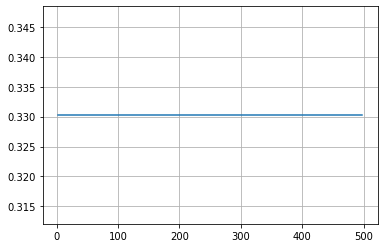

In [ ]:
plt.plot(list(range(2,500,2)), k_vs_score)
plt.grid(True)
plt.show()

In [ ]:
selector = SelectKBest(score_func=f_regression, k=30)
selector.fit(X_train0, y_train0)

SelectKBest(k=30, score_func=<function f_regression at 0x7ff5a1673a70>)

In [ ]:
selector.get_support()

array([False, False, False, ..., False, False, False])

## LGBMClassifier

In [ ]:
k_vs_score = []
for k in range(2, 500, 2):
  selector = SelectKBest(score_func=f_regression, k=k)

  X_train0_prepared = selector.fit_transform(X_train0, y_train0)
  X_train1_prepared = selector.transform(X_train1)

  mdl = LGBMClassifier(num_leaves=1000,min_child_samples=155, learning_rate=0.008157175918157098, 
                        n_estimators=490, random_state=42)
  mdl.fit(X_train0_prepared, y_train0)
  y_scores = mdl.predict_proba(X_train1_prepared)[:, 1]
  precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (y_scores >= thrs).astype(int)
  _, metric = evaluate(y_pred, y_train1, plot_matrix=False)

  k_vs_score.append(metric)
  print("k = {} - F1 = {}".format(k, metric))

k = 2 - F1 = 0.4909657320872274
k = 4 - F1 = 0.5255376344086021
k = 6 - F1 = 0.5262449528936743
k = 8 - F1 = 0.5262449528936743
k = 10 - F1 = 0.5262449528936743
k = 12 - F1 = 0.5262449528936743
k = 14 - F1 = 0.5269382391590013
k = 16 - F1 = 0.5269382391590013
k = 18 - F1 = 0.5402087170042971
k = 20 - F1 = 0.5434650455927053
k = 22 - F1 = 0.5434650455927053
k = 24 - F1 = 0.5434650455927053
k = 26 - F1 = 0.5434650455927053
k = 28 - F1 = 0.5434650455927053
k = 30 - F1 = 0.5434650455927053
k = 32 - F1 = 0.5426642111724985
k = 34 - F1 = 0.5437956204379562
k = 36 - F1 = 0.5437956204379562
k = 38 - F1 = 0.5417937766931056
k = 40 - F1 = 0.5421245421245421
k = 42 - F1 = 0.5425597060624617
k = 44 - F1 = 0.5397196261682244
k = 46 - F1 = 0.5397196261682244
k = 48 - F1 = 0.5400350672121567
k = 50 - F1 = 0.5421020282728949
k = 52 - F1 = 0.5416149068322982
k = 54 - F1 = 0.542079207920792
k = 56 - F1 = 0.5445783132530121
k = 58 - F1 = 0.5464917284654877
k = 60 - F1 = 0.5504252733900364
k = 62 - F1 = 0

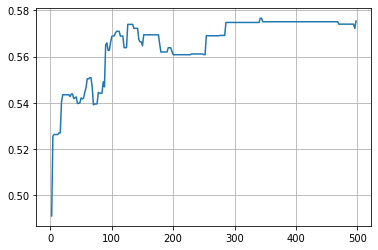

In [ ]:
plt.plot(list(range(2,500,2)), k_vs_score)
plt.grid(True)
plt.show()

## XGBClassifier

In [ ]:
k_vs_score = []
for k in range(500, 600, 2):
  selector = SelectKBest(score_func=f_regression, k=k)

  X_train0_prepared = selector.fit_transform(X_train0, y_train0)
  X_train1_prepared = selector.transform(X_train1)

  mdl = XGBClassifier(learning_rate=0.05,
                    n_estimators=1000,
                    random_state=42)

  mdl.fit(X_train0_prepared, y_train0)
  y_scores = mdl.predict_proba(X_train1_prepared)[:, 1]
  precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (y_scores >= thrs).astype(int)
  _, metric = evaluate(y_pred, y_train1, plot_matrix=False)

  k_vs_score.append(metric)
  print("k = {} - F1 = {}".format(k, metric))

k = 500 - F1 = 0.5659369994660972
k = 502 - F1 = 0.5651027938850817
k = 504 - F1 = 0.5674987264391238
k = 506 - F1 = 0.5674987264391238
k = 508 - F1 = 0.5646817248459959
k = 510 - F1 = 0.5683563748079877
k = 512 - F1 = 0.5705521472392638
k = 514 - F1 = 0.5674987264391238
k = 516 - F1 = 0.5676500508646999
k = 518 - F1 = 0.5667752442996743
k = 520 - F1 = 0.5667752442996743
k = 522 - F1 = 0.5667752442996743
k = 524 - F1 = 0.5667752442996743
k = 526 - F1 = 0.5667752442996743
k = 528 - F1 = 0.5706993363961205
k = 530 - F1 = 0.5684626791893229
k = 532 - F1 = 0.5705645161290323
k = 534 - F1 = 0.5663082437275985
k = 536 - F1 = 0.5663082437275985
k = 538 - F1 = 0.5663082437275985
k = 540 - F1 = 0.5663082437275985
k = 542 - F1 = 0.5686771414090218
k = 544 - F1 = 0.5694022289766971
k = 546 - F1 = 0.5694235588972432
k = 548 - F1 = 0.5698492462311558
k = 550 - F1 = 0.56973293768546
k = 552 - F1 = 0.5714285714285714
k = 554 - F1 = 0.5714285714285714
k = 556 - F1 = 0.5714285714285714
k = 558 - F1 = 0

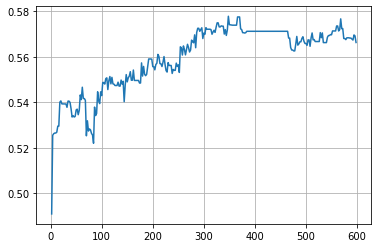

In [ ]:
plt.plot(list(range(2,600,2)), k_vs_score)
plt.grid(True)
plt.show()

## Random Forest

In [ ]:
k_vs_score = []
for k in range(2, 600, 2):
  selector = SelectKBest(score_func=f_regression, k=k)

  X_train0_prepared = selector.fit_transform(X_train0, y_train0)
  X_train1_prepared = selector.transform(X_train1)

  mdl = RandomForestClassifier(n_estimators=700, min_samples_leaf=15, random_state=42)
  mdl.fit(X_train0_prepared, y_train0)
  y_scores = mdl.predict_proba(X_train1_prepared)[:, 1]
  precisions, recalls, thresholds = precision_recall_curve(y_train1, y_scores)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (y_scores >= thrs).astype(int)
  _, metric = evaluate(y_pred, y_train1, plot_matrix=False)

  k_vs_score.append(metric)
  print("k = {} - F1 = {}".format(k, metric))

k = 2 - F1 = 0.4909657320872274
k = 4 - F1 = 0.5255376344086021
k = 6 - F1 = 0.5262449528936743
k = 8 - F1 = 0.5265993265993266
k = 10 - F1 = 0.5265993265993266
k = 12 - F1 = 0.5265993265993266
k = 14 - F1 = 0.526954177897574
k = 16 - F1 = 0.526954177897574
k = 18 - F1 = 0.539779681762546
k = 20 - F1 = 0.543134872417983
k = 22 - F1 = 0.5429093122337187
k = 24 - F1 = 0.5421467556094602
k = 26 - F1 = 0.5421467556094602
k = 28 - F1 = 0.5421467556094602
k = 30 - F1 = 0.5431192660550458
k = 32 - F1 = 0.5431192660550458
k = 34 - F1 = 0.5420219244823387
k = 36 - F1 = 0.5420219244823387
k = 38 - F1 = 0.539227895392279
k = 40 - F1 = 0.5392156862745098
k = 42 - F1 = 0.5397412199630315
k = 44 - F1 = 0.5396435156730178
k = 46 - F1 = 0.5376607470912431
k = 48 - F1 = 0.5379710144927536
k = 50 - F1 = 0.5386064030131826
k = 52 - F1 = 0.5379310344827586
k = 54 - F1 = 0.538647342995169
k = 56 - F1 = 0.540084388185654
k = 58 - F1 = 0.5407577497129736
k = 60 - F1 = 0.5420895522388061
k = 62 - F1 = 0.54204

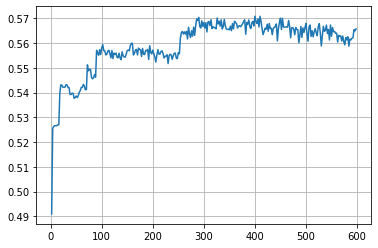

In [ ]:
plt.plot(list(range(2,600,2)), k_vs_score)
plt.grid(True)
plt.show()